<a href="https://colab.research.google.com/github/meichenfang/Poisson-regression/blob/main/find-weight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

**Denote the gene expression matrix by $X_{ij}$ where j is gene index and i is cell index. In summary, we assume a specific model of transcription and want to solve**

\begin{align}
    & \text{argmax}_{\theta_j} \sum_{j} \sum_i \ln P(\mathcal{X}_{ij},t_i; \theta_j,\tau).
\end{align}

We assume t follows a uniform distribution on [0,1]. We use alternative minimization/EM-like algorithm to find optimal θ.

In [1]:
import time
from MC_functions import *
from EM_functions import *

## EM_functions.py

## plot functions

In [208]:
cmps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis']

def plot_t(weight,ax=None,t=None):
    m=np.shape(weight)[-1]
    h=np.linspace(0,1,m)
    t_hat=np.sum(weight*h[None,None,:],axis=(-2,-1))
    if ax is None:
        fig, ax = plt.subplots(1,1)
    if t is not None:
        ord=np.argsort(t)
        # build a rectangle in axes coords
        left, width = .25, .5
        bottom, height = .25, .5
        right = left + width
        top = bottom + height
       
        ax.imshow(weight[ord,0,:],aspect="auto");
        ax.text(right, top,"cor="+str(np.around(np.corrcoef(t_hat,t)[0,1],2)), horizontalalignment='right', 
                 verticalalignment='top', transform=ax.transAxes, color="white");
    else:
        ord=np.argsort(t_hat)
        ax.imshow(weight[ord,:],aspect="auto");

def plot_theta(theta,theta_hat):
    K=np.shape(theta)[1]-4
    fig, ax = plt.subplots(1,K+4,figsize=(6*(K+4),4))

    for i in range(K):
        ax[i].plot(theta[:,i],theta[:,i]);
        ax[i].plot(theta[:,i],theta_hat[:,i],'.');
        ax[i].set_title("a"+str(i+1))
        ax[i].set_xlabel("true values")

    ax[-4].plot(theta[:,-4],theta[:,-4]);
    ax[-4].plot(theta[:,-4],theta_hat[:,-4],'.');
    ax[-4].set_title("u0")
    ax[-4].set_ylabel("fitted values")
    ax[-4].set_xlabel("true values")

    ax[-3].plot(theta[:,-3],theta[:,-3]);
    ax[-3].plot(theta[:,-3],theta_hat[:,-3],'.');
    ax[-3].set_title("s0")
    ax[-3].set_ylabel("fitted values")
    ax[-3].set_xlabel("true values")

    ax[-2].plot(theta[:,-2],theta[:,-2]);
    ax[-2].plot(theta[:,-2],theta_hat[:,-2],'.');
    ax[-2].set_title("beta");
    ax[-2].set_xlabel("true values");

    ax[-1].plot(theta[:,-1],theta[:,-1]);
    ax[-1].plot(theta[:,-1],theta_hat[:,-1],'.');
    ax[-1].set_title("gamma");
    ax[-1].set_xlabel("true values");
    
    for i in range(K+4):
        ax[i].set_xscale('log')
        ax[i].set_yscale('log')


def plot_theta_hat(theta_hat,K,gene_list):
    fig, ax = plt.subplots(K+4,1,figsize=(12,4*(K+4)))

    for i in range(K+4):
        ax[i].scatter(np.array(gene_list), np.log(theta_hat[:,i]));

    ax[0].set_title("log a1");
    ax[1].set_title("log a2");
    ax[2].set_title("log u0");
    ax[3].set_title("log s0");
    ax[4].set_title("log beta");
    ax[5].set_title("log gamma");


def plot_y(theta,theta_hat,weight,tau,gene_list):
    m=np.shape(weight)[1]
    p=np.shape(theta_hat)[0]
    h=np.linspace(0,1,m)
    t_hat=np.sum(weight*h[None,:],axis=1)
    y_hat = get_Y(theta_hat, t_hat, tau)
    y = get_Y(theta, t_hat, tau)
    fig, ax = plt.subplots(p,2,figsize=(12,4*p))
    for i in range(p):
        ax[i,0].plot(t_hat,X[:,i,0],'.',color="gray");
        ax[i,0].plot(t_hat,y_hat[:,i,0],'b.', label = 'fit');
        ax[i,0].plot(t_hat,y[:,i,0],'r.',label = 'true');
        ax[i,0].set_title(gene_list[i]+" unspliced")

        ax[i,1].plot(t_hat,X[:,i,1],'.',color="gray");
        ax[i,1].plot(t_hat,y_hat[:,i,1],'b.', label = 'fit');
        ax[i,1].plot(t_hat,y[:,i,1],'r.', label = 'true');
        ax[i,1].set_title(gene_list[i]+" spliced")
        ax[i,1].legend()

def plot_t(weight,ax=None,t=None):
    m=np.shape(weight)[1]
    h=np.linspace(0,1,m)
    t_hat=np.sum(weight*h[None,:],axis=1)
    if ax is None:
        fig, ax = plt.subplots(1,1)
    if t is not None:
        ord=np.argsort(t)
        # build a rectangle in axes coords
        left, width = .25, .5
        bottom, height = .25, .5
        right = left + width
        top = bottom + height
       
        ax.imshow(weight[ord,:],aspect="auto");
        ax.text(right, top,"cor="+str(np.around(np.corrcoef(t_hat,t)[0,1],2)), horizontalalignment='right', 
                 verticalalignment='top', transform=ax.transAxes, color="white");
    else:
        ord=np.argsort(t_hat)
        ax.imshow(weight[ord,:],aspect="auto");

def plot_theta_hat(theta_hat,K,gene_list=None):
    if gene_list is None:
        gene_list = np.arange(len(theta_hat))
    fig, ax = plt.subplots(K+4,1,figsize=(12,4*(K+4)))
    ax[0].scatter(np.array(gene_list), theta_hat[:,0]);
    ax[-3].scatter(np.array(gene_list), theta_hat[:,-3]);
    for i in range(1,K+1):
        ax[i].scatter(np.array(gene_list), theta_hat[:,i]-theta_hat[:,0]);
        
    for i in range(-2,0):
        ax[i].scatter(np.array(gene_list), theta_hat[:,i]);

    ax[0].set_title("a1");
    ax[1].set_title("a2 - a1");
    ax[2].set_title("u0 - a1");
    ax[3].set_title("s0");
    ax[4].set_title("beta");
    ax[5].set_title("gamma");


def plot_y(X,theta_hat,weight,tau,gene_list):
    m=np.shape(weight)[1]
    p=np.shape(theta_hat)[0]
    h=np.linspace(0,1,m)
    t_hat=np.sum(weight*h[None,:],axis=1)
    y_hat = get_Y(theta_hat, t_hat, tau)
    fig, ax = plt.subplots(2,p,figsize=(6*p,8))
    if p==1:
        i=0
        ax[0].scatter(t_hat,X[:,i,0],c=colors20[np.mod(clusters, 20)]);
        ax[0].plot(t_hat,y_hat[:,i,0],'r.');
        ax[0].set_title(gene_list[0]+" unspliced")

        ax[1].scatter(t_hat,X[:,i,1],c=colors20[np.mod(clusters, 20)]);
        ax[1].plot(t_hat,y_hat[:,i,1],'r.');
        ax[1].set_title(gene_list[0]+" spliced")
    else:
        for i in range(p):
            ax[0,i].scatter(t_hat,X[:,i,0],c=colors20[np.mod(clusters, 20)]);
            ax[0,i].plot(t_hat,y_hat[:,i,0],'r.');
            ax[0,i].set_title(gene_list[i]+" unspliced")

            ax[1,i].scatter(t_hat,X[:,i,1],c=colors20[np.mod(clusters, 20)]);
            ax[1,i].plot(t_hat,y_hat[:,i,1],'r.');
            ax[1,i].set_title(gene_list[i]+" spliced")

            
            
def plot_phase(X,theta_hat,weight,theta_G,gene_list=None):
    if gene_list is None:
        gene_list = np.arange(len(theta_hat))
        
    if type(theta_G) is dict:
        n,L,m = np.shape(weight)
        Q = weight.copy()
        tau = theta_G["tau"]
        topo = theta_G["topo"]
        
    else:       
        n,m = np.shape(weight)
        Q = weight.copy()
        Q = Q[:,None,:]
        tau = theta_G
        topo = np.array([np.arange(len(tau)-1)])
    
    p=np.shape(theta_hat)[0]
    h=np.linspace(0,1,m)
    fig, ax = plt.subplots(1,p,figsize=(6*p,4))
    if p==1:
        i=0
        ax.scatter(X[:,i,0],X[:,i,1],c='lightgray');
        ax.set_title(gene_list[0])

    else:
        for i in range(p):
            ax[i].scatter(X[:,i,0],X[:,i,1],c='lightgray');
            ax[i].set_title(gene_list[i])
    
    Y_hat = np.zeros((L,n,p,2))
    for l in range(L):
        t_hat=np.sum(Q[:,l,:]*h[None,:],axis=1)
        theta_l_hat = np.concatenate((theta_hat[:,topo[l]], theta_hat[:,-4:]), axis=1)
        Y_hat[l] = get_Y(theta_l_hat,t_hat,tau) # m*p*2
        y_hat = Y_hat[l]
        if p==1:
            i=0
            ax.scatter(y_hat[:,i,0],y_hat[:,i,1],c=t_hat,cmap=cmps[l]);
        else:
            for i in range(p):
                ax[i].scatter(y_hat[:,i,0],y_hat[:,i,1],c=t_hat,cmap=cmps[l]);
                         

# Test

Note that inference of $\alpha$ is much accurate than $\beta$ and $\gamma$, because even under a uniform prior when n is not too large, moving $\beta$ and $\gamma$ together with posterior a little bit does not change likelihood that much

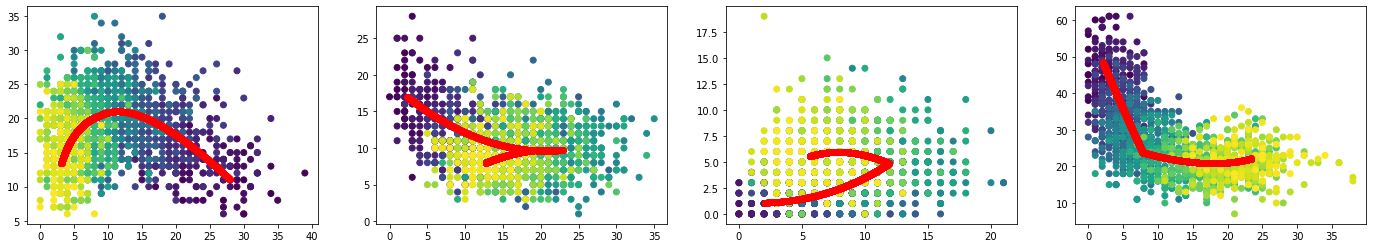

In [89]:
#%% generate data
np.random.seed(42)
n = 1500
p = 4
t = np.linspace(0, 1, n)

Tau=[0,0.5]
tau=(0,0.5,1)

K=len(tau)-1
theta=np.zeros((p,K+4))
theta[:,0]=np.exp(np.random.uniform(0,4,size=p))
theta[:,1]=np.exp(np.random.uniform(0,4,size=p))
theta[:,-3]=np.exp(np.random.uniform(0,4,size=p))
theta[:,-4]=np.exp(np.random.uniform(0,4,size=p))
theta[:,-1]=np.exp(np.random.uniform(0,2,size=p))
theta[:,-2]=np.exp(np.random.uniform(0,2,size=p))

Y = get_Y(theta,t,tau)

X = np.random.poisson(Y)

fig, ax = plt.subplots(1,p,figsize=(6*p,4))
for i in range(p):
    ax[i].scatter(X[:,i,0],X[:,i,1],c=t);
    ax[i].scatter(Y[:,i,0],Y[:,i,1],c='r');

## Given true theta, it's able to find reasonable posterior

In [103]:
#%% generate data
np.random.seed(42)
n = 2000
m = 1000
p = 20

tau=(0,0.5,1)
topo = np.array([[0,1],[0,2]])
n_states=len(set(topo.flatten()))
if n_states < len(tau)-1:
    print("check tau and topo")
t = np.linspace(0, 1, m)

theta=np.zeros((p,n_states+4))
for k in range(n_states+2):
    theta[:,k]=np.exp(np.random.uniform(0,5,size=p))
    
theta[:,-2]=np.exp(np.random.uniform(0,3,size=p))
theta[:,-1]=np.exp(np.random.uniform(0,3,size=p))

Y = np.zeros((n,p,2))
for l in range(len(topo)):
    theta_l = np.concatenate((theta[:,topo[l]], theta[:,-4:]), axis=1)
    Y[l*m:(l+1)*m] = get_Y(theta_l,t,tau) # m*p*2
    
X = np.random.poisson(Y)

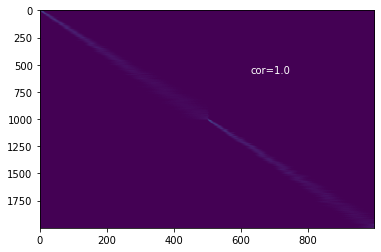

In [106]:
weight = update_weight(X,theta,tau,topo,m)
plot_t(weight, ax=None, t=np.append(t,t))

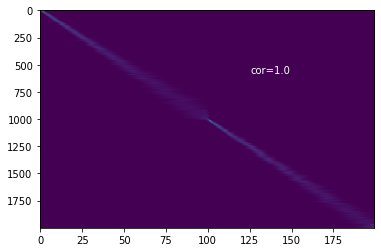

In [108]:
m=int(n/10)

weight = update_weight(X,theta,tau,topo,m)
plot_t(weight, ax=None, t=np.append(t,t))

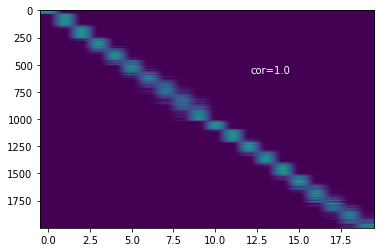

In [109]:
m=int(n/100)

weight = update_weight(X,theta,tau,topo,m)
plot_t(weight, ax=None, t=np.append(t,t))

## Given true time, it's able to estimate theta

In [187]:
#%% generate data
np.random.seed(84)
n = 2000
m = 1000
p = 4

tau=(0,1)
topo = np.array([[0],[1]])
theta_G={"tau":tau,"topo":topo}
n_states=len(set(topo.flatten()))
if n_states < len(tau)-1:
    print("check tau and topo")
t = np.linspace(0, 1, m)

theta=np.zeros((p,n_states+4))
for k in range(n_states+2):
    theta[:,k]=np.exp(np.random.uniform(0,5,size=p))
    
theta[:,-2]=np.exp(np.random.uniform(0,3,size=p))
theta[:,-1]=np.exp(np.random.uniform(0,3,size=p))

Y = np.zeros((n,p,2))
for l in range(len(topo)):
    theta_l = np.concatenate((theta[:,topo[l]], theta[:,-4:]), axis=1)
    Y[l*m:(l+1)*m] = get_Y(theta_l,t,tau) # m*p*2
    
X = np.random.poisson(Y)

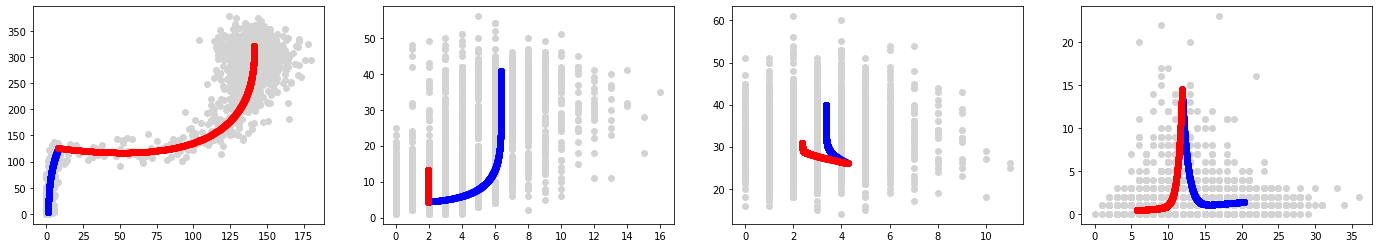

In [188]:
fig, ax = plt.subplots(1,p,figsize=(6*p,4))
for i in range(p):
    ax[i].scatter(X[:,i,0],X[:,i,1],c='lightgray');
    ax[i].scatter(Y[:m,i,0],Y[:m,i,1],c='b');
    ax[i].scatter(Y[m:,i,0],Y[m:,i,1],c='r');

In [198]:
weight=np.diag(v=[1]*m)
weight1 = np.append(weight,np.zeros((m,m)),axis=0)
weight2 = np.append(np.zeros((m,m)),weight,axis=0)
Q=np.stack([weight1,weight2], axis=1)
Q.shape

(2000, 2, 1000)

CPU times: user 115 ms, sys: 104 ms, total: 219 ms
Wall time: 58.3 s


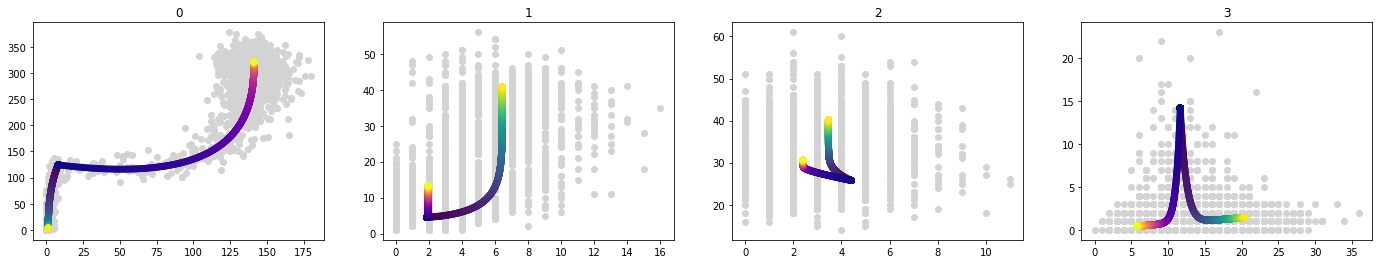

In [220]:
#%% update theta
%time theta_hat = update_theta(X,Q,theta_G,penalty=0,parallel=True,n_threads=4)
plot_phase(X,theta_hat,Q,theta_G)

CPU times: user 119 ms, sys: 91.2 ms, total: 210 ms
Wall time: 55.6 s


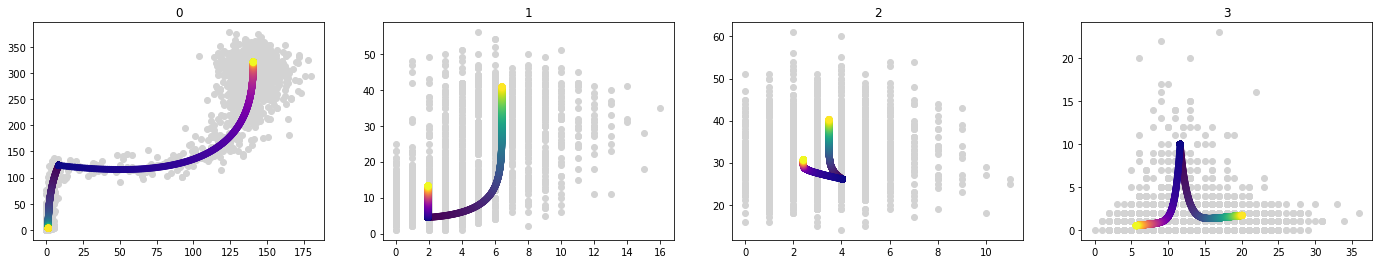

In [222]:
#%% update theta
%time theta_hat = update_theta(X,Q,theta_G,penalty=n*0.001,parallel=True,n_threads=4)
plot_phase(X,theta_hat,Q,theta_G)

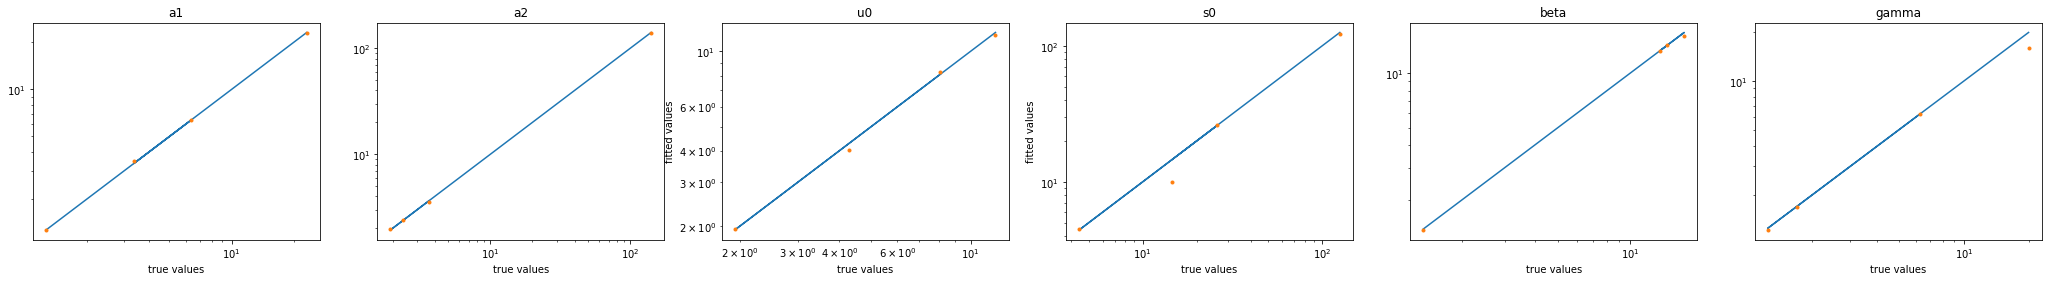

In [223]:
plot_theta(theta[:,],theta_hat)

Thu Jul 21 14:08:49 PDT 2022
CPU times: user 249 ms, sys: 113 ms, total: 363 ms
Wall time: 4min 23s


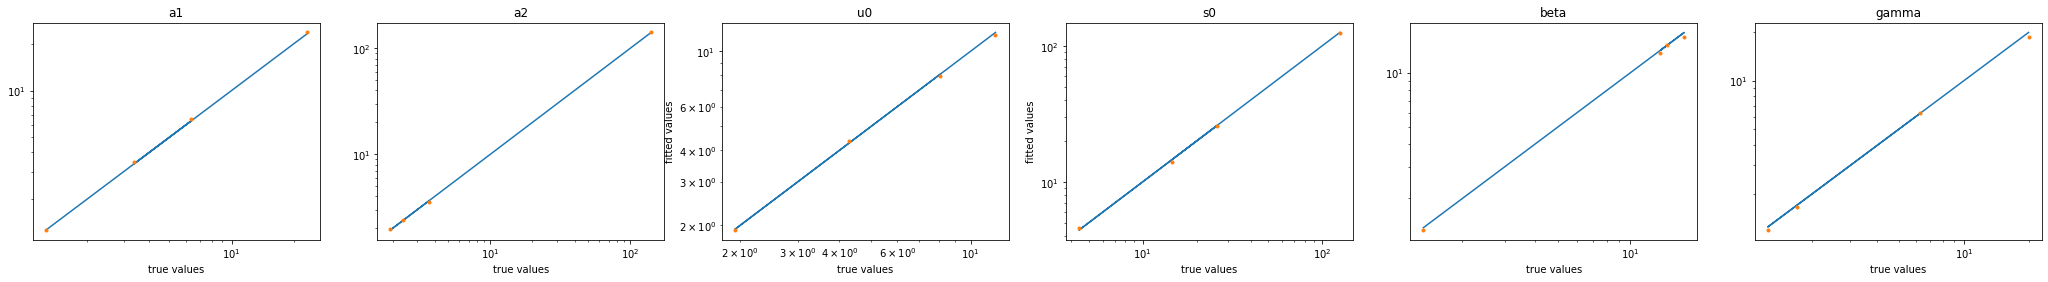

In [215]:
%time theta_hat=update_theta(X,Q,theta_G,alternative=True, parallel=True,n_threads=min(4,p),theta0=None)
plot_theta(theta[:,],theta_hat)

## Given uninformative time, estimation is terrible

In [12]:
m=int(n/10)
weight=np.ones((n,m))
weight = weight/weight.sum(axis=1,keepdims=True)

In [13]:
beta0=3
theta0 = beta0*np.ones((p,K+4))
theta0[:,0:(K+2)]=np.mean(X[:,:,0],axis=0)[:,None]/beta0
theta0[:,-1] = np.mean(X[:,:,0],axis=0)/(np.mean(X[:,:,1],axis=0)+eps)*beta0

In [18]:
%time theta_hat=update_theta(X,weight,tau,penalty=0,parallel=True,n_threads=min(40,p),theta0=theta0)

CPU times: user 15.9 ms, sys: 149 ms, total: 165 ms
Wall time: 3.04 s


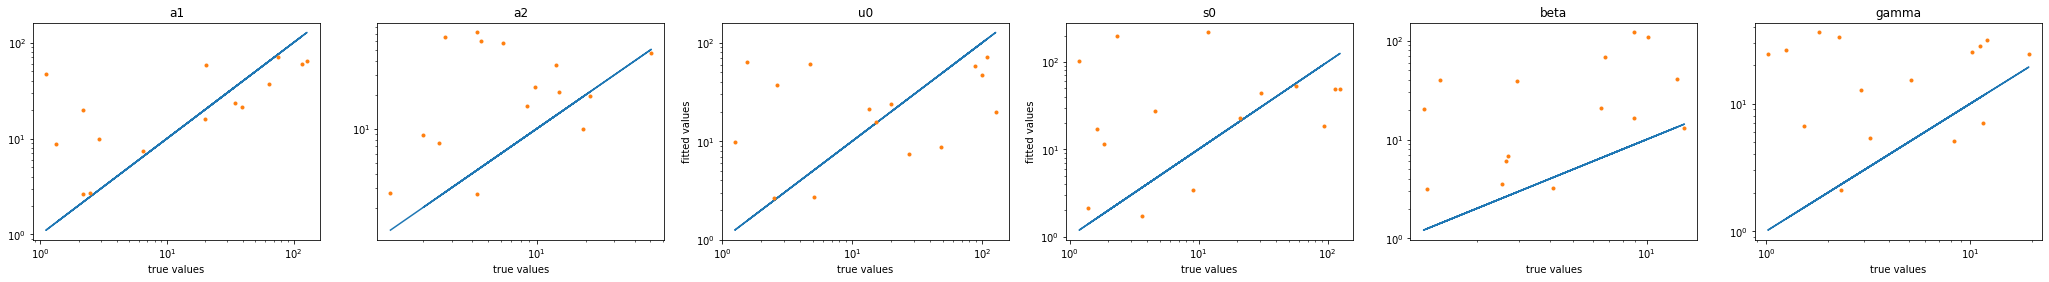

In [19]:
plot_theta(theta,theta_hat)

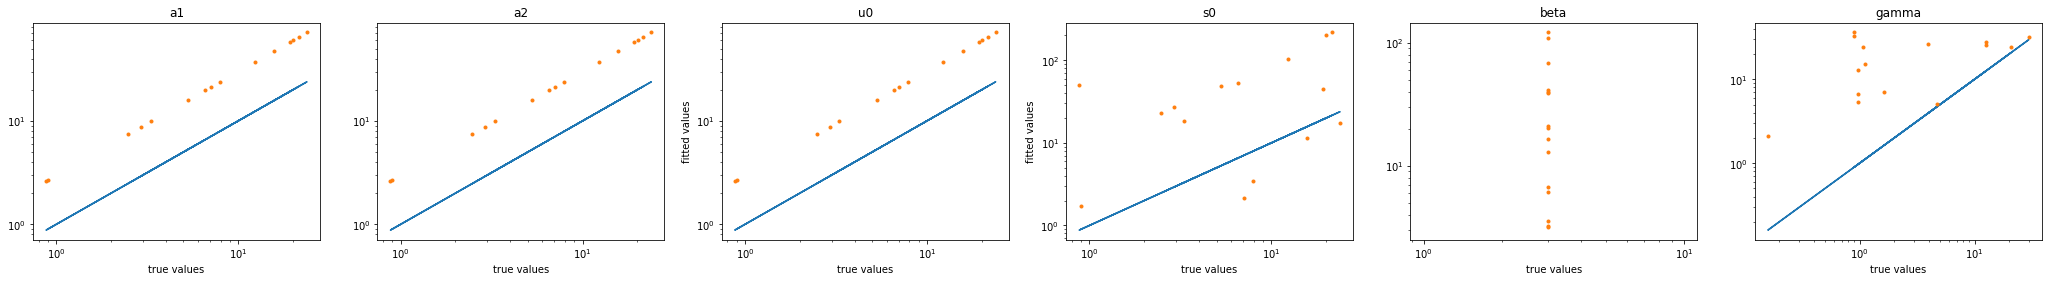

In [20]:
plot_theta(theta0,theta_hat)

In [25]:
%time theta_hat_a=update_theta(X,weight,tau,penalty=0,alternative=True, parallel=True,n_threads=min(40,p),theta0=theta0)

CPU times: user 31.7 ms, sys: 137 ms, total: 169 ms
Wall time: 16 s


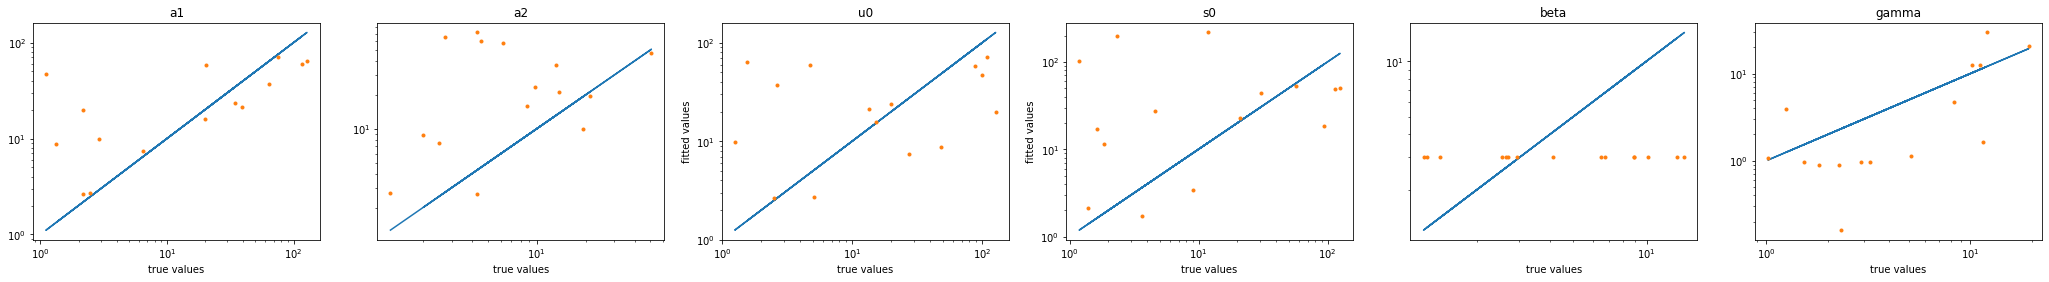

In [26]:
plot_theta(theta,theta_hat_a)

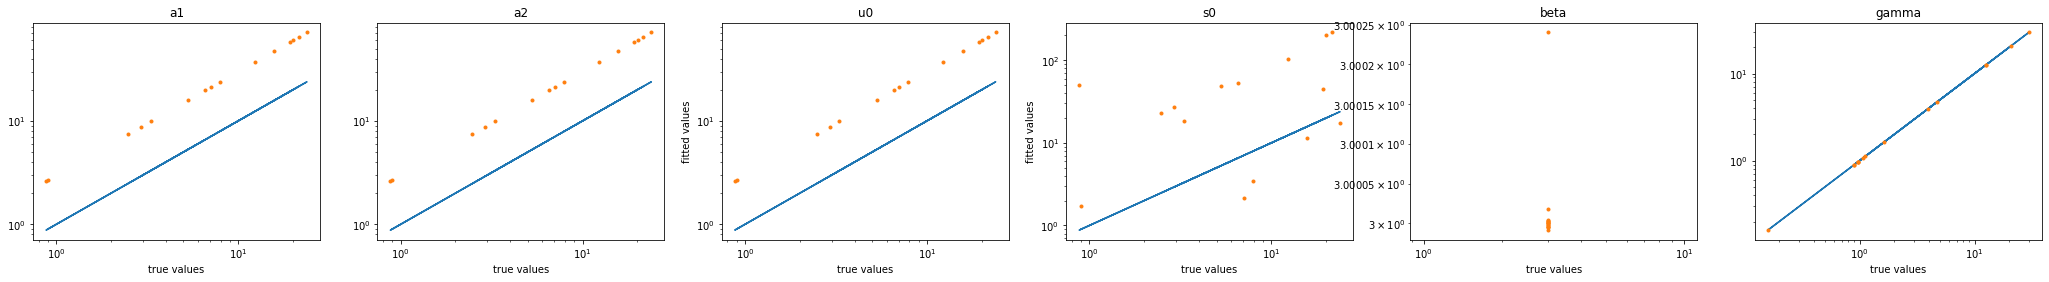

In [27]:
plot_theta(theta0,theta_hat_a)

In [28]:
weight = update_weight(X,theta_hat,tau,m)

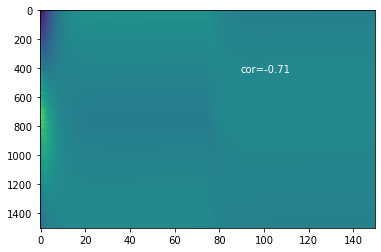

In [29]:
plot_t(weight, ax=None, t=t)

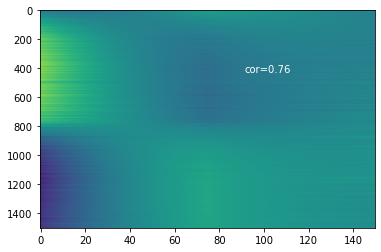

In [30]:
weight = update_weight(X,theta_hat_a,tau,m)
plot_t(weight, ax=None, t=t)

### Therefor, a warm start is necessary!

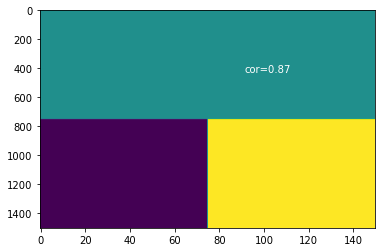

In [7]:
m=int(n/10)
weight0=np.ones((n,m))
weight0[int(n/2):,int(m/2):] += 0.1
weight0 = weight0/weight0.sum(axis=1,keepdims=True)
plot_t(weight0, ax=None, t=t)

In [35]:
%time theta_hat=update_theta(X,weight,tau,penalty=0,parallel=True,n_threads=min(40,p),theta0=theta0)

CPU times: user 42.7 ms, sys: 121 ms, total: 164 ms
Wall time: 2.85 s


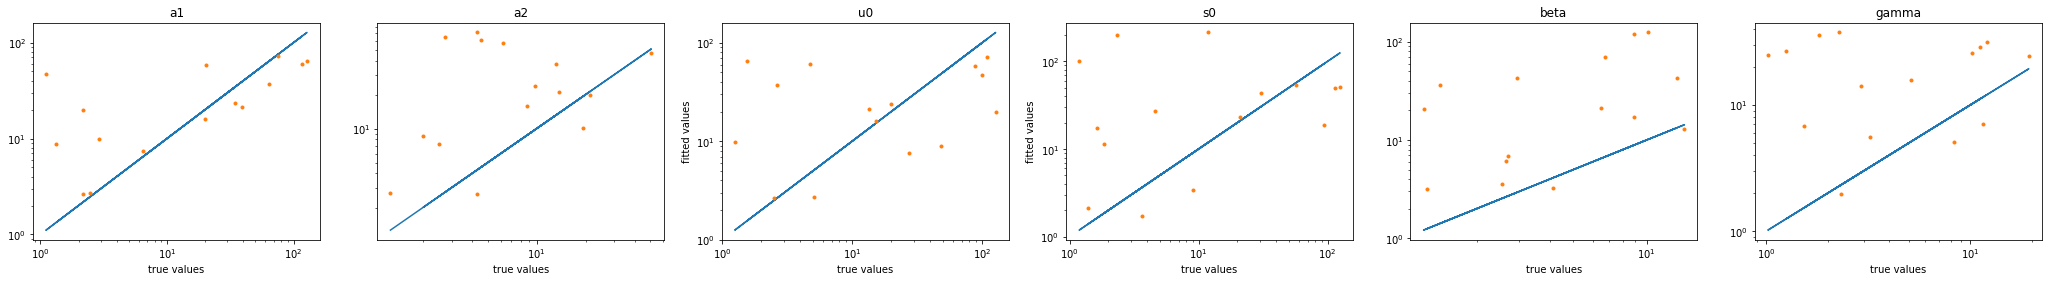

In [36]:
plot_theta(theta,theta_hat)

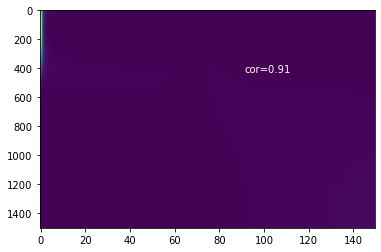

In [37]:
weight = update_weight(X,theta_hat,tau,m)
plot_t(weight, ax=None, t=t)

## traj_EM

### Close look at one example

In [40]:
#%% generate data
np.random.seed(2022)
n = 1500
p = 15
t = np.linspace(0, 1, n)

Tau=[0,0.5]
tau=(0,0.5,1)

K=len(tau)-1
theta=np.zeros((p,K+4))
theta[:,0]=np.exp(np.random.uniform(0,5,size=p))
theta[:,1]=np.exp(np.random.uniform(0,5,size=p))
theta[:,-3]=np.exp(np.random.uniform(0,5,size=p))
theta[:,-4]=np.exp(np.random.uniform(0,5,size=p))
theta[:,-1]=np.exp(np.random.uniform(0,3,size=p))
theta[:,-2]=np.exp(np.random.uniform(0,3,size=p))

Y = get_Y(theta,t,tau)

X = np.random.poisson(Y)

theta_hat_hist, weight_hist = traj_EM(X, tau, weight0, epoch=20, parallel = True, n_threads = min(40,p))

100%|██████████| 20/20 [00:46<00:00,  2.35s/it]


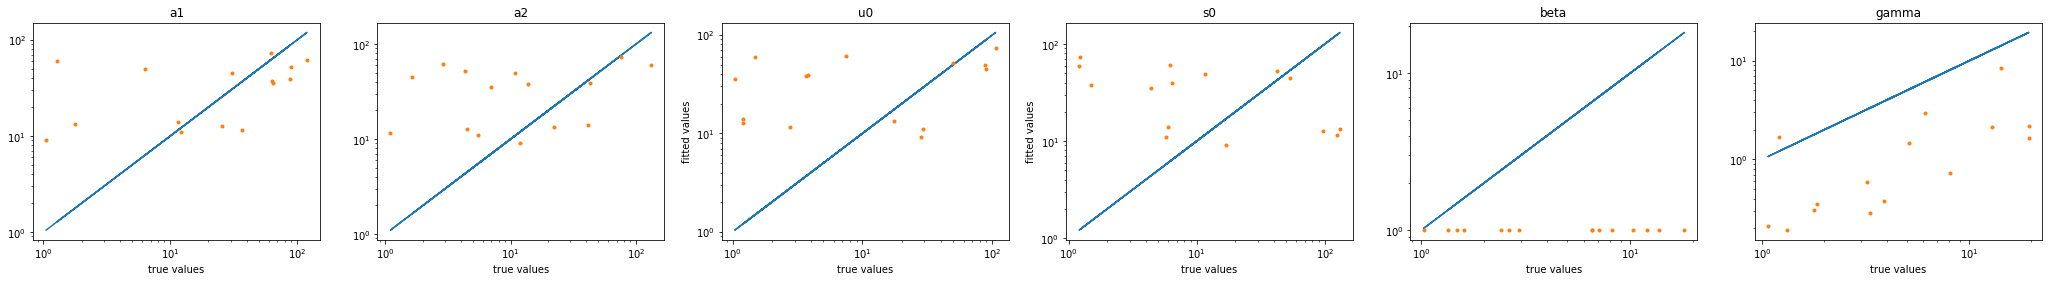

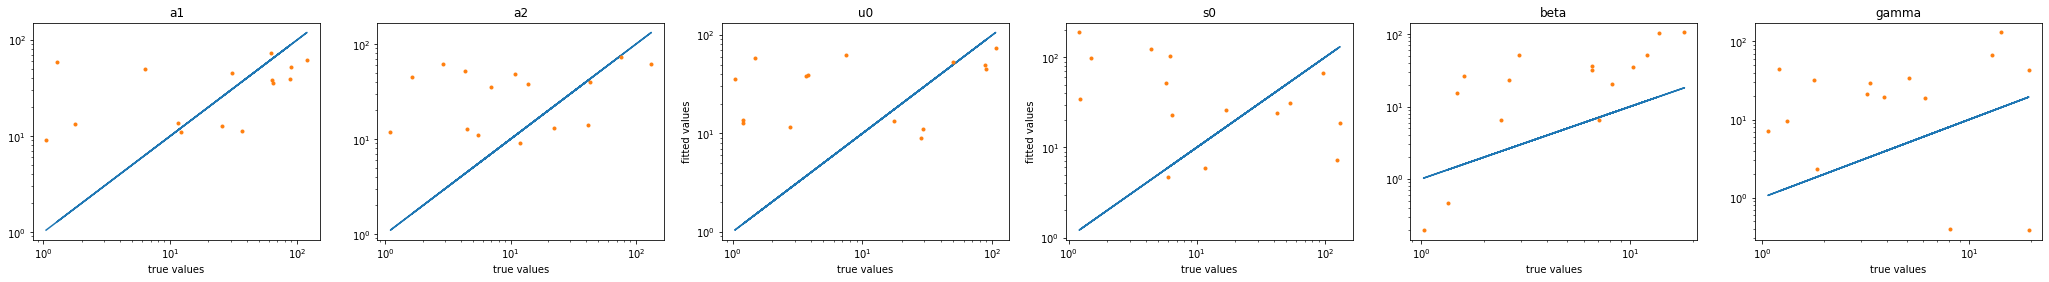

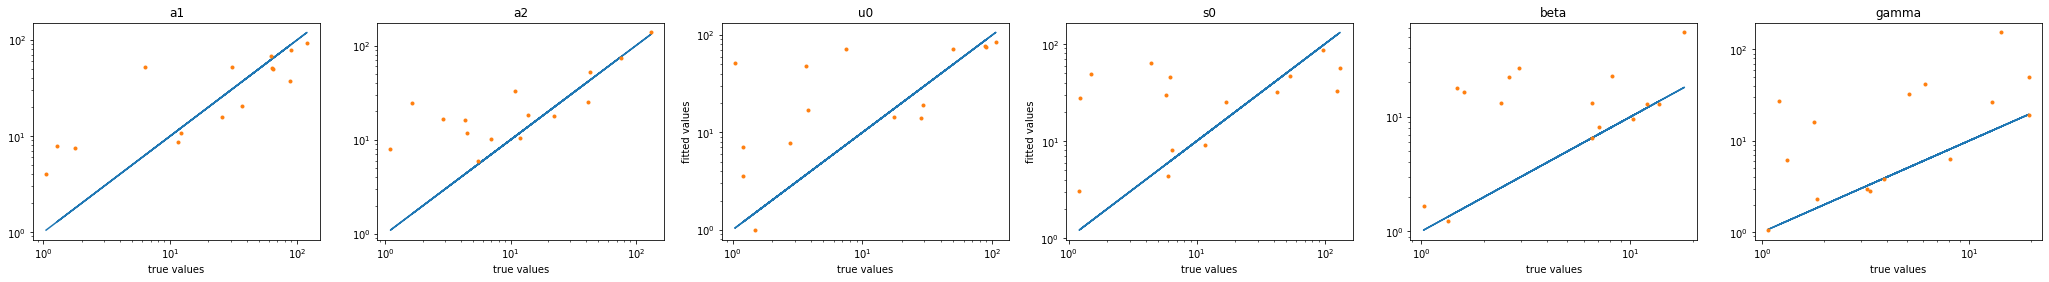

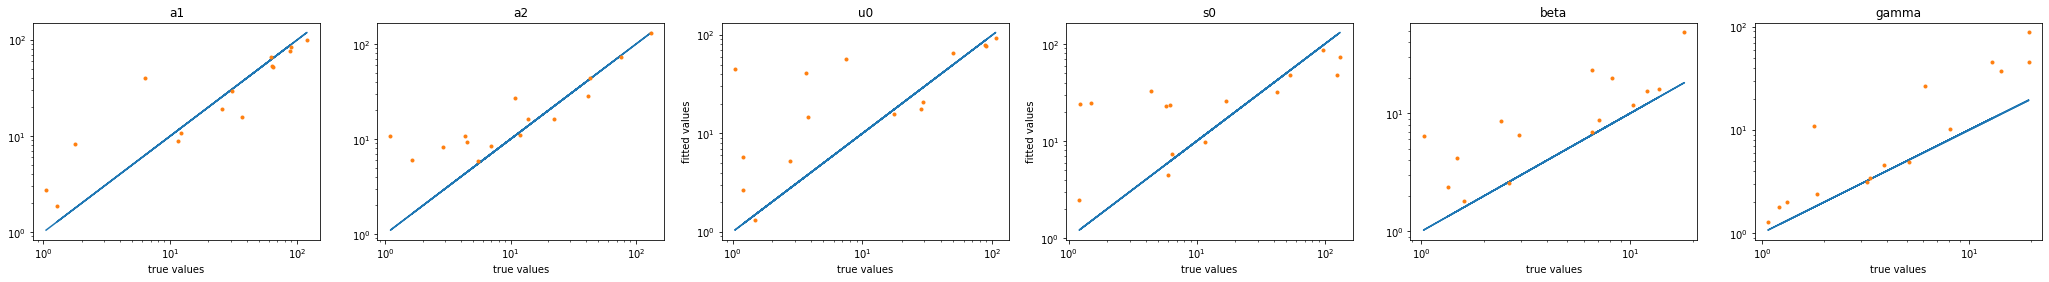

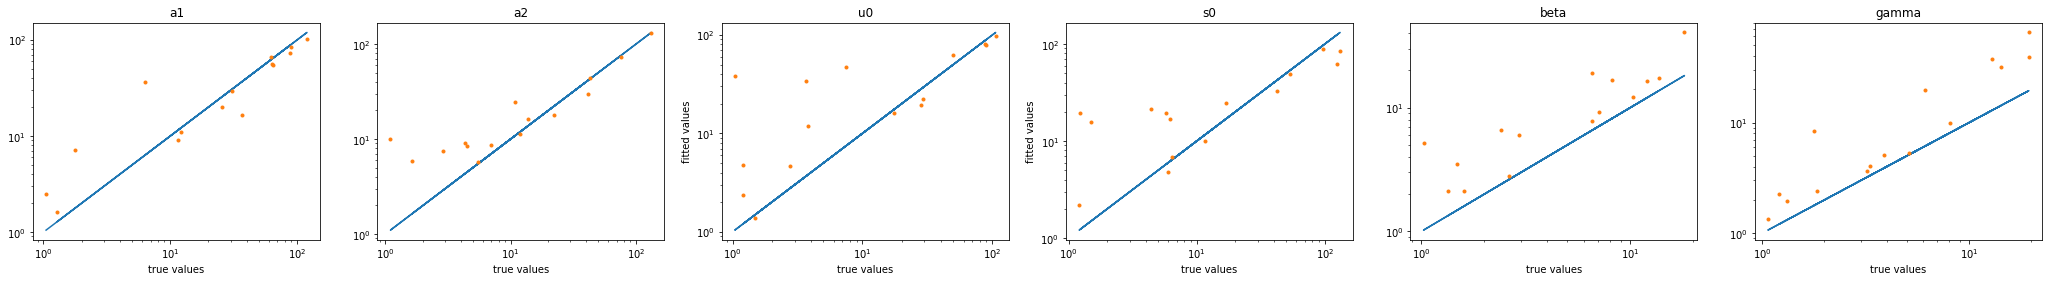

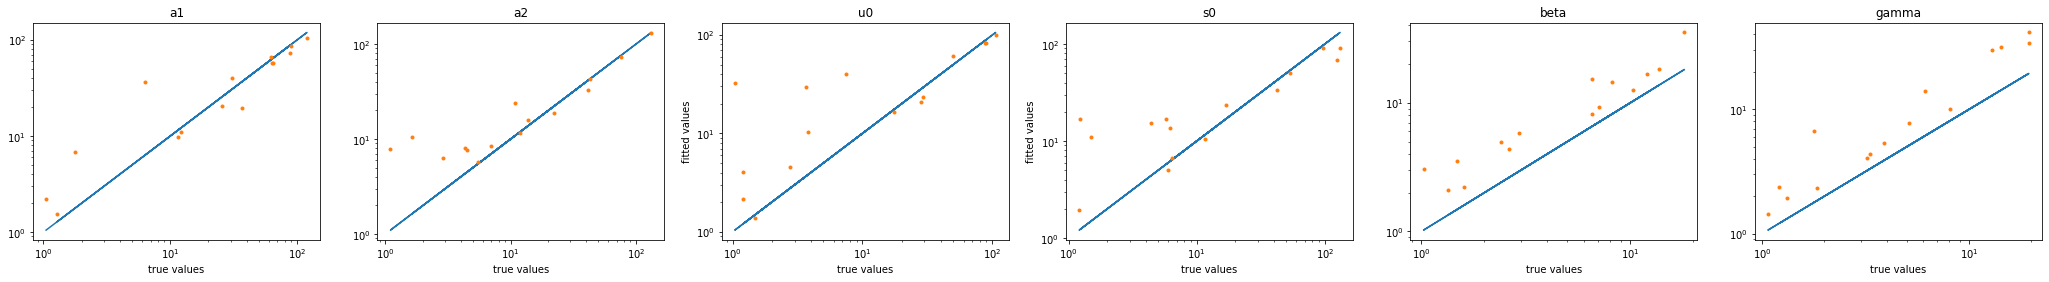

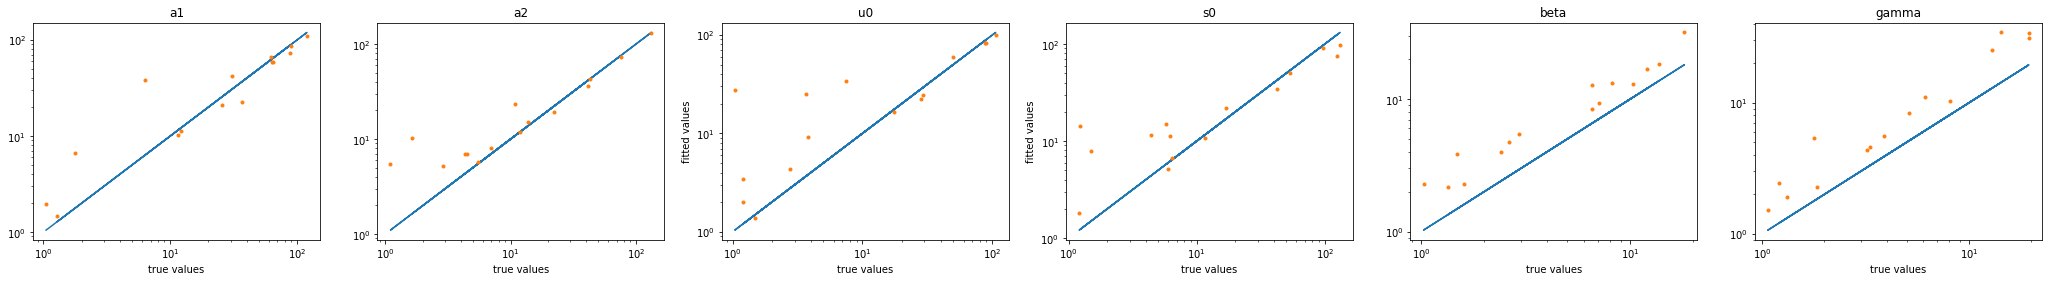

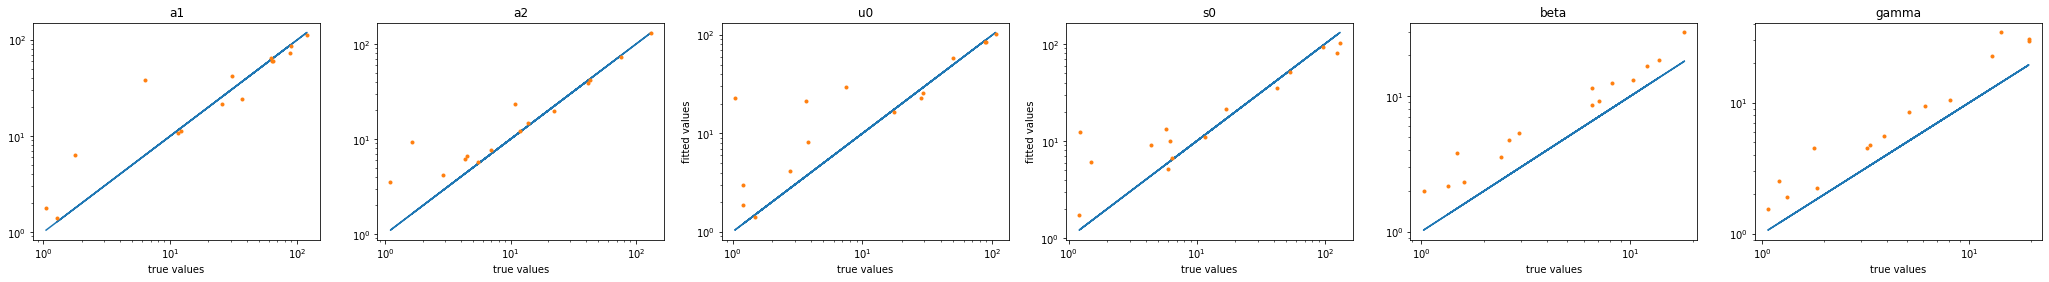

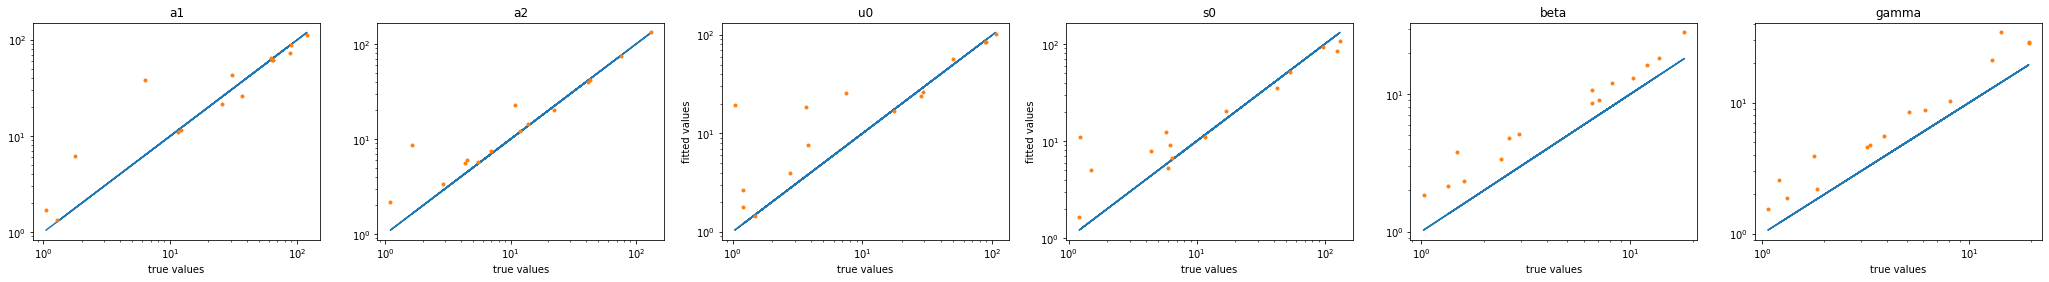

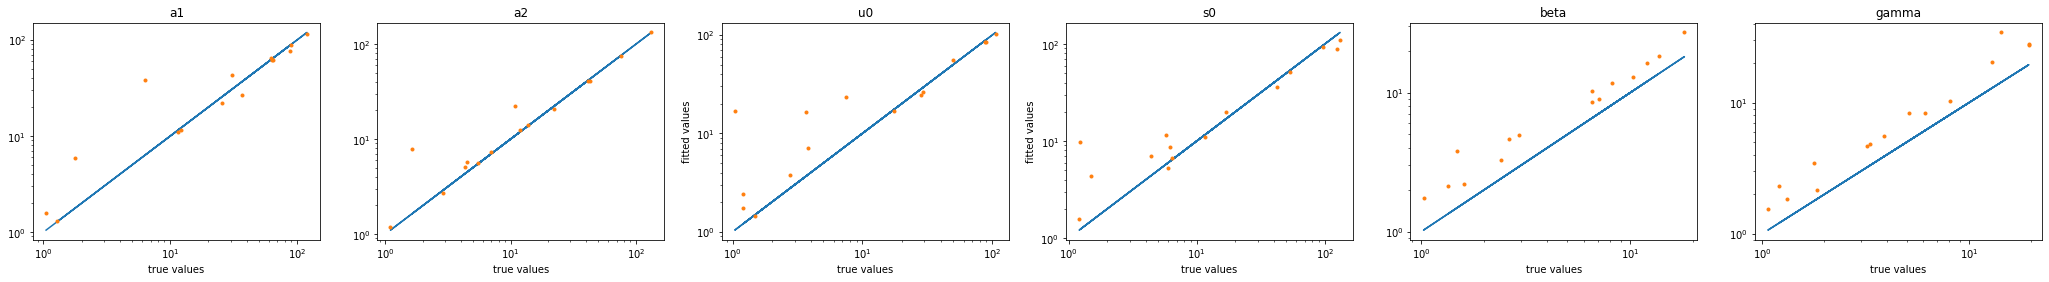

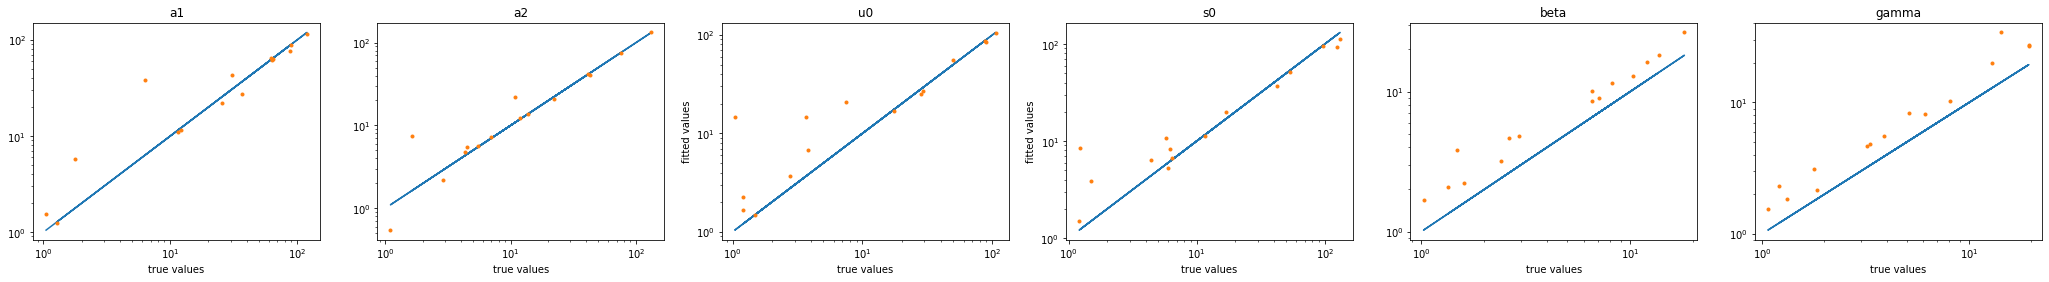

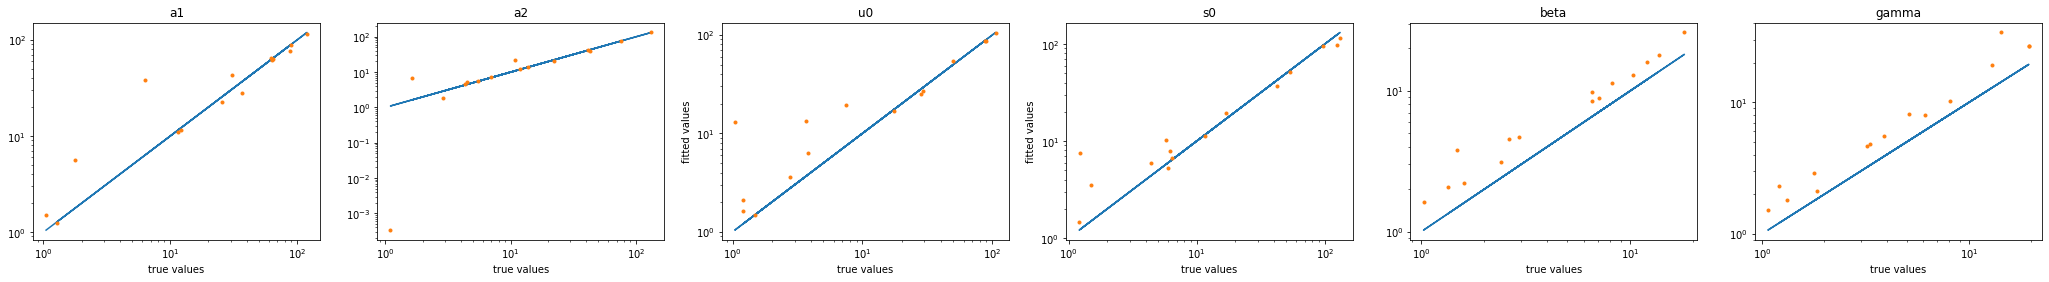

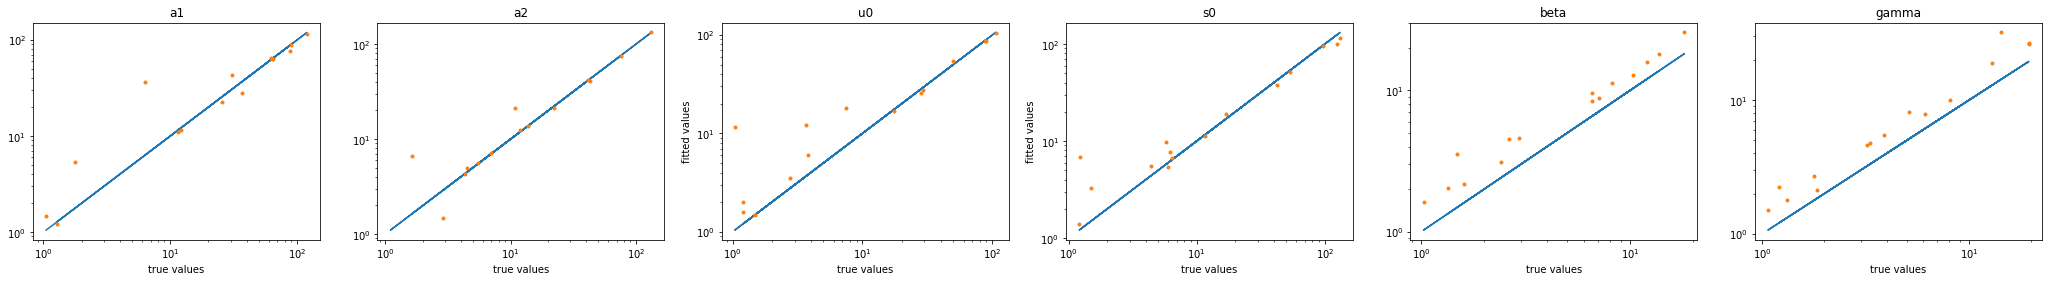

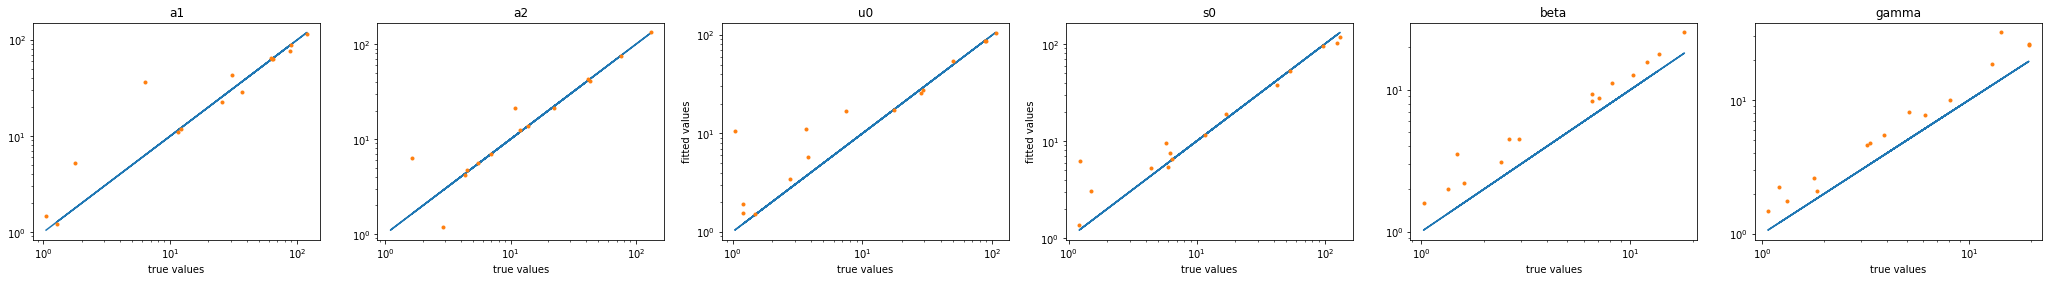

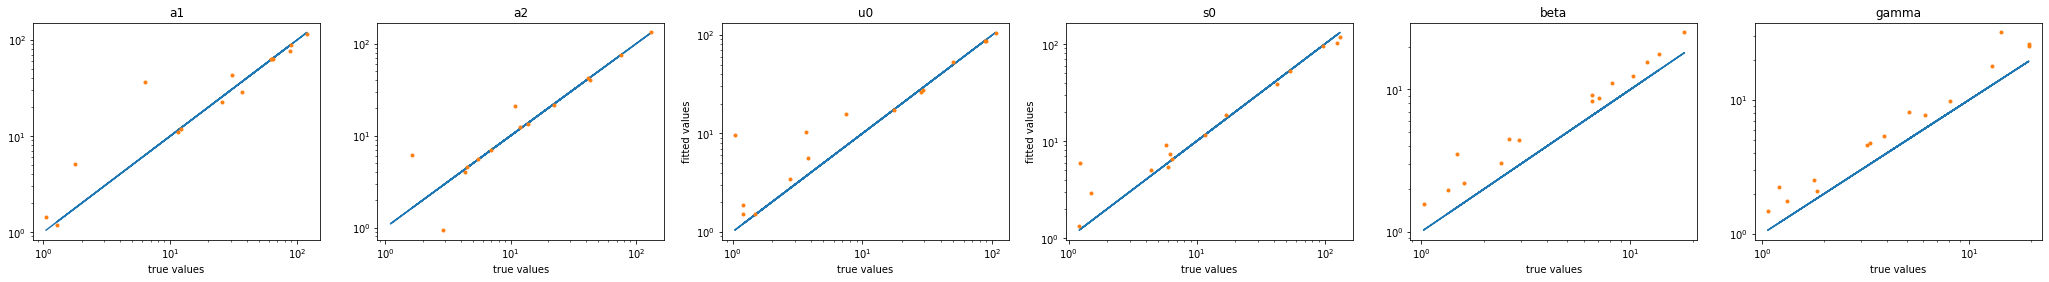

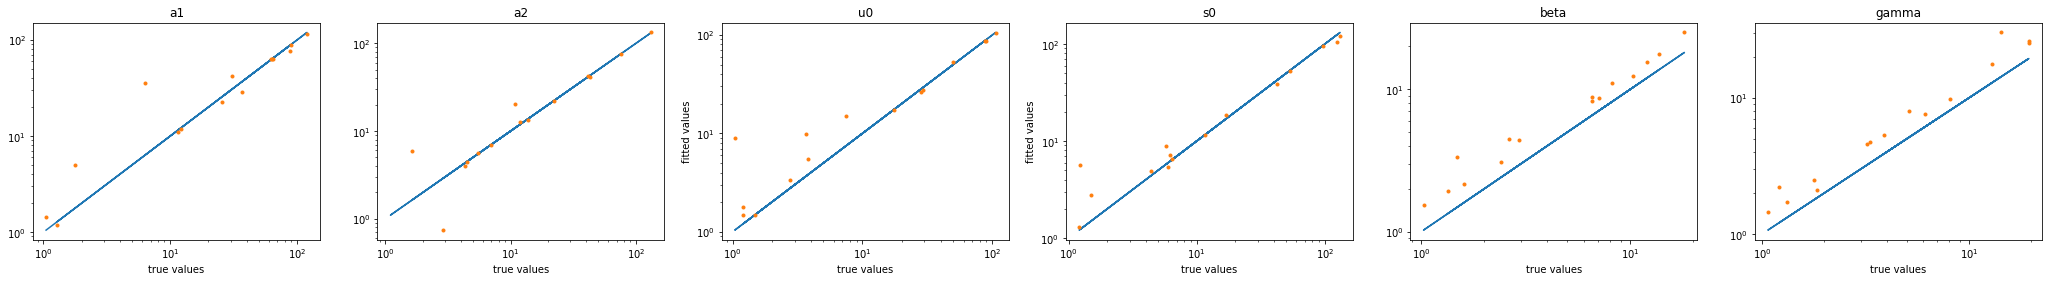

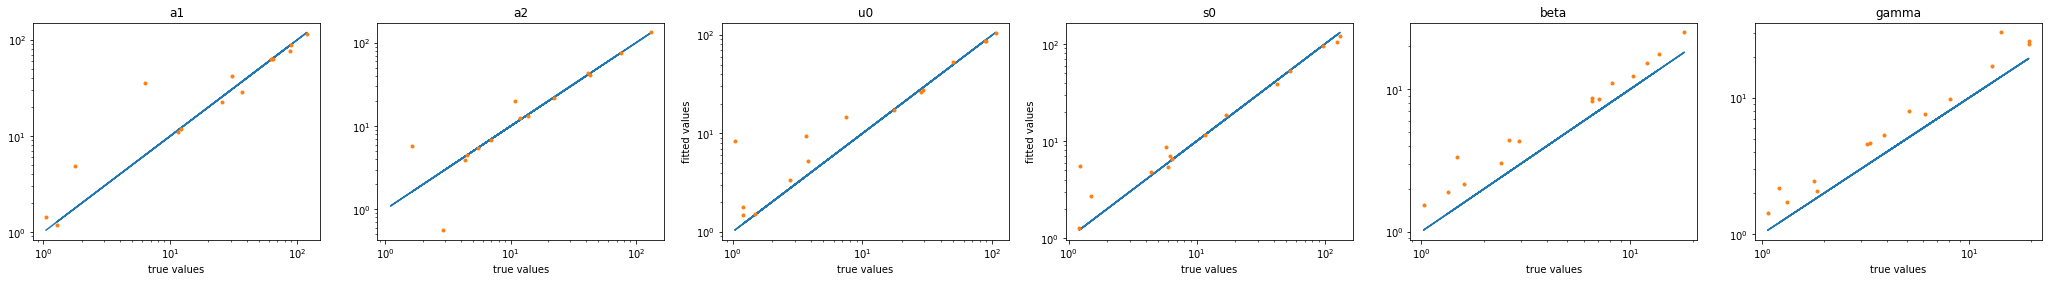

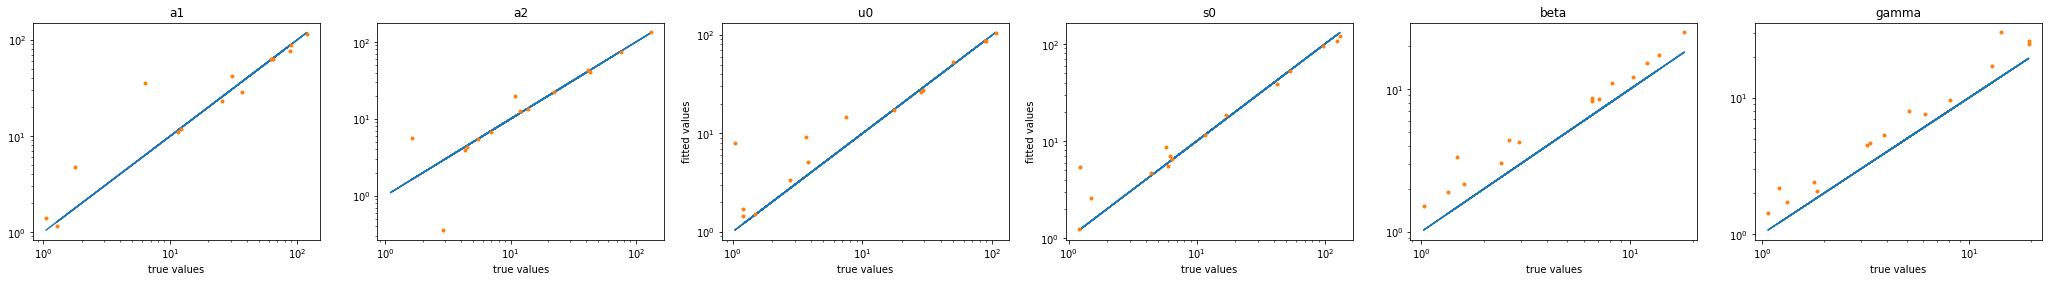

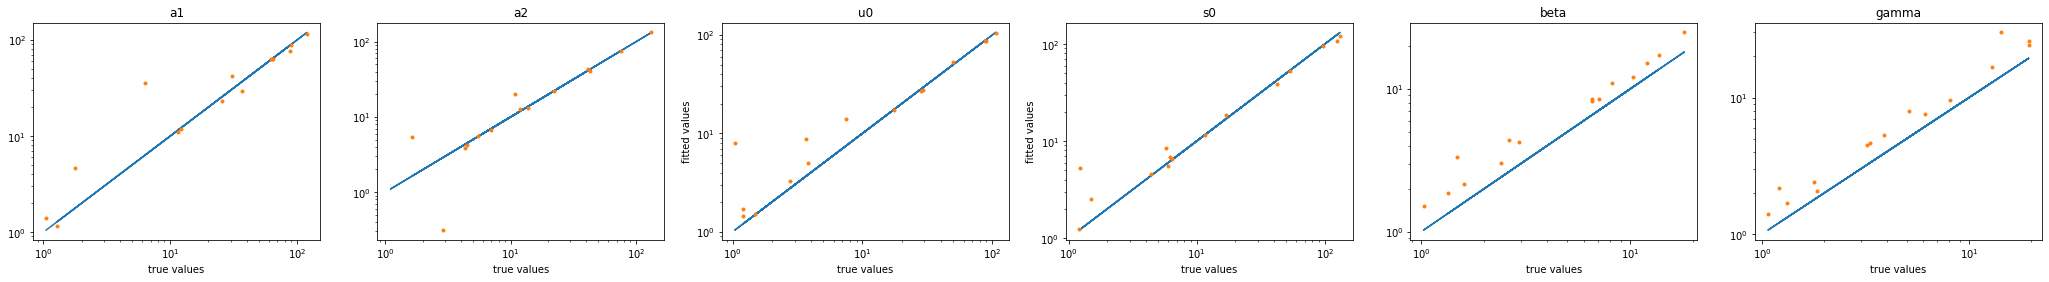

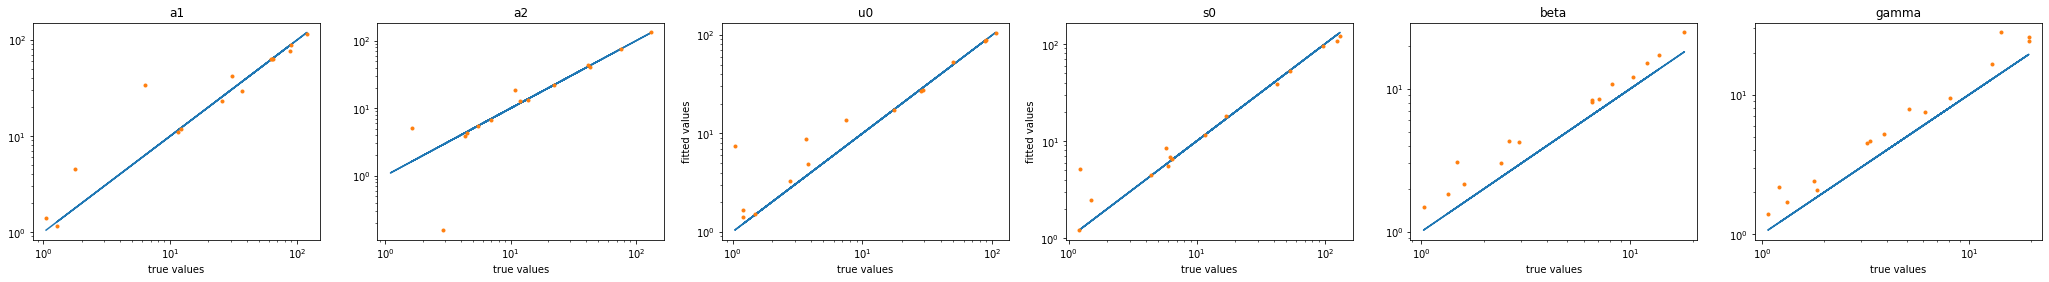

In [41]:
for i in range(20):
  plot_theta(theta,theta_hat_hist[i])

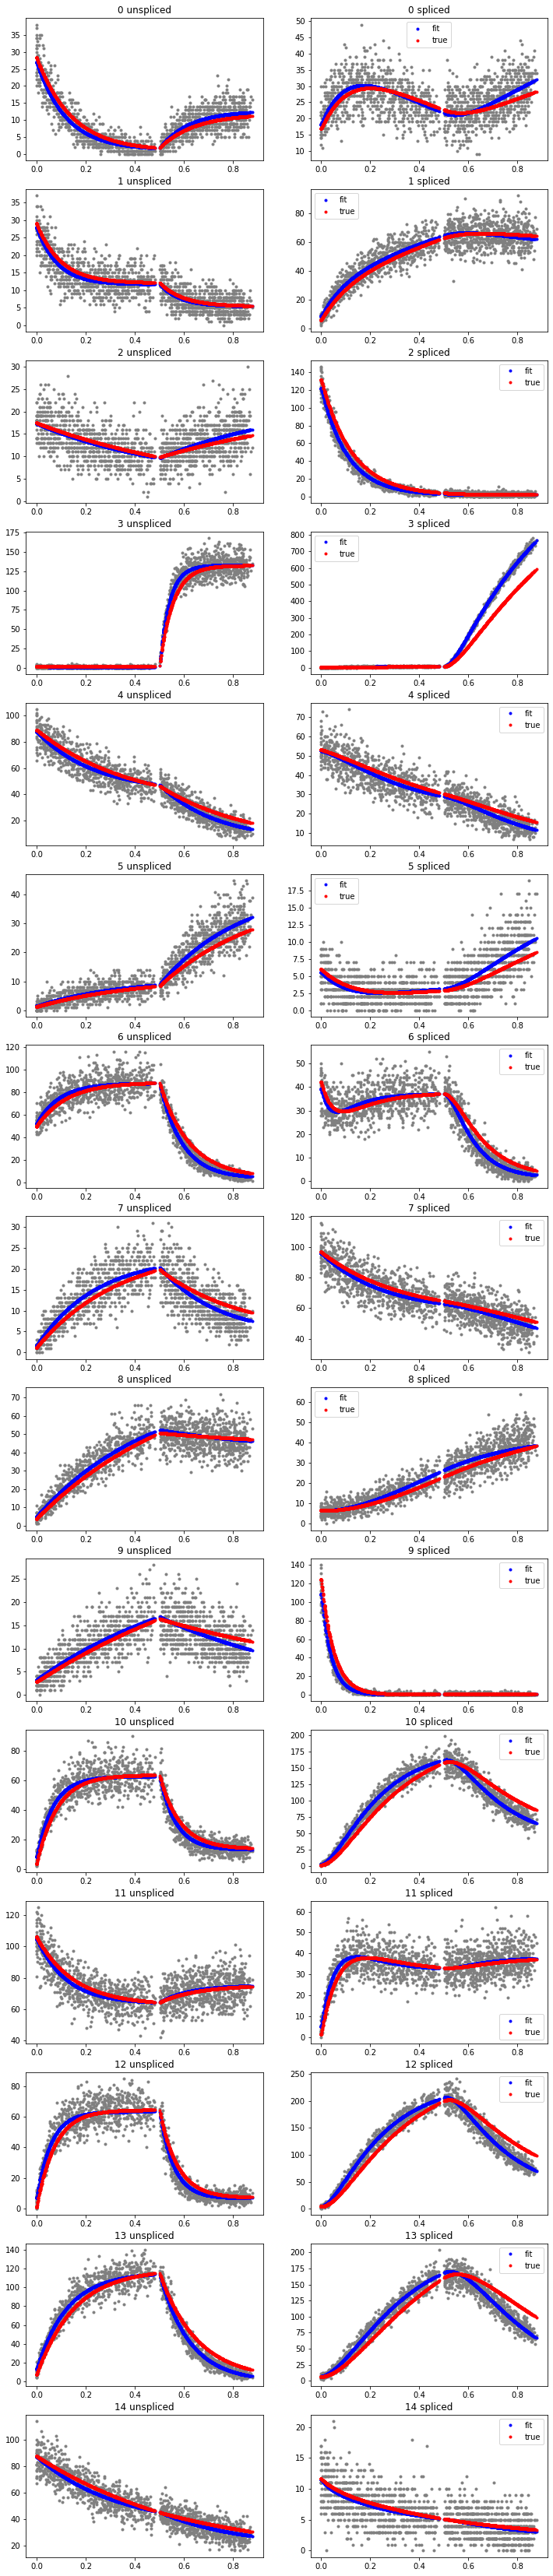

In [43]:
plot_y(theta,theta_hat_hist[-1],weight_hist[-1],tau,[str(i) for i in range(20)])

# Test

An informative gene should have moderate beta and gamma value, not too small so that there are dynamics, and also not too large so that the dynamics are a significant part of data.

In [43]:
def get_fit_result(n, rs=[0.01, 1/30, 0.1], warm=True, add_null=False, true_tau=None, relative_penalty=0, loga_max=4, logb_max=2, seeds=[21, 42, 63, 84], cores=20):
    tau=(0,0.5,1)
    if true_tau is None:
        true_tau = tau
    K=len(tau)-1
    t = np.linspace(0, 1, n)

    m=int(n/10)
    weight0=np.ones((n,m))
    if warm:
        weight0[int(n/2):,int(m/2):] += 0.1
    weight0 = weight0/weight0.sum(axis=1,keepdims=True)
    
    #fig, axs = plt.subplots(len(rs), K+4+len(seeds), figsize=(6*(K+4+len(seeds)),4*len(rs)))
    thetas=[]
    theta_hats=[]
    weights=[]
    
    for i,r in enumerate(rs): 
        true_p = int(n*r)  
        if add_null:
            p = 2*true_p
        else:
            p = true_p

        for j,seed in enumerate(seeds):
            np.random.seed(seed)
            theta=np.zeros((p,K+4))
            theta[:,0]=np.exp(np.random.uniform(0,loga_max,size=p))-1
            theta[:,1]=np.exp(np.random.uniform(0,loga_max,size=p))-1
            theta[:,-4]=np.exp(np.random.uniform(0,loga_max,size=p))-1
            theta[:,-3]=np.exp(np.random.uniform(0,loga_max,size=p))-1
            theta[:,-2]=np.exp(np.random.uniform(0,logb_max,size=p))
            theta[:,-1]=np.exp(np.random.uniform(0,logb_max,size=p))
            theta[true_p:,-2]=1
            theta[true_p:,-1]=theta[true_p:,-4]/theta[true_p:,-3]
            theta[true_p:,0]=theta[true_p:,-4]
            theta[true_p:,1]=theta[true_p:,-4]
            theta[true_p:,-3]=theta[true_p:,-4]/theta[true_p:,-3]
            thetas.append(theta)
            
            Y = get_Y(theta,t,true_tau)
            X = np.random.poisson(Y)

            theta_hat_hist, weight_hist = traj_EM(X, tau, weight0, relative_penalty=relative_penalty, epoch=20, parallel = True, n_threads = min(cores,p))
            theta_hat = theta_hat_hist[-1]
            theta_hats.append(theta_hat)
            weight=weight_hist[-1]
            weights.append(weight)
    
    return thetas, theta_hats, weights


def plot_fit_result(n, rs=[0.01, 1/30, 0.1], warm=True, add_null=False, true_tau=None, relative_penalty=0, loga_max=4, logb_max=2, seeds=[21, 42, 63, 84], cores=20):
    tau=(0,0.5,1)
    if true_tau is None:
        true_tau = tau
    K=len(tau)-1
    t = np.linspace(0, 1, n)

    m=int(n/10)
    weight0=np.ones((n,m))
    if warm:
        weight0[int(n/2):,int(m/2):] += 0.1
    weight0 = weight0/weight0.sum(axis=1,keepdims=True)
    
    fig, axs = plt.subplots(len(rs), K+4+len(seeds), figsize=(6*(K+4+len(seeds)),4*len(rs)))
    thetas=[]
    theta_hats=[]
    weights=[]
    
    for i,r in enumerate(rs): 
        true_p = int(n*r)  
        if add_null:
            p = 2*true_p
        else:
            p = true_p

        for j,seed in enumerate(seeds):
            np.random.seed(seed)
            theta=np.zeros((p,K+4))
            theta[:,0]=np.exp(np.random.uniform(0,loga_max,size=p))-1
            theta[:,1]=np.exp(np.random.uniform(0,loga_max,size=p))-1
            theta[:,-4]=np.exp(np.random.uniform(0,loga_max,size=p))-1
            theta[:,-3]=np.exp(np.random.uniform(0,loga_max,size=p))-1
            theta[:,-2]=np.exp(np.random.uniform(0,logb_max,size=p))
            theta[:,-1]=np.exp(np.random.uniform(0,logb_max,size=p))
            theta[true_p:,-2]=1
            theta[true_p:,-1]=theta[true_p:,-4]/theta[true_p:,-3]
            theta[true_p:,0]=theta[true_p:,-4]
            theta[true_p:,1]=theta[true_p:,-4]
            theta[true_p:,-3]=theta[true_p:,-4]/theta[true_p:,-3]
            thetas.append(theta)
            
            Y = get_Y(theta,t,true_tau)
            X = np.random.poisson(Y)

            theta_hat_hist, weight_hist = traj_EM(X, tau, weight0, relative_penalty=relative_penalty, epoch=20, parallel = True, n_threads = min(cores,p))
            theta_hat = theta_hat_hist[-1]
            theta_hats.append(theta_hat)
            weight=weight_hist[-1]
            weights.append(weight)
            
            for k in range(K+4):
                axs[i,k].loglog(theta[:,k],theta_hat[:,k],'.')
                axs[i,k].loglog(theta[:,k],theta[:,k],'k')
    
            plot_t(weight, ax=axs[i,K+4+j], t=t)
        
    return


## Warm start and different n

100%|██████████| 20/20 [05:44<00:00, 17.25s/it]


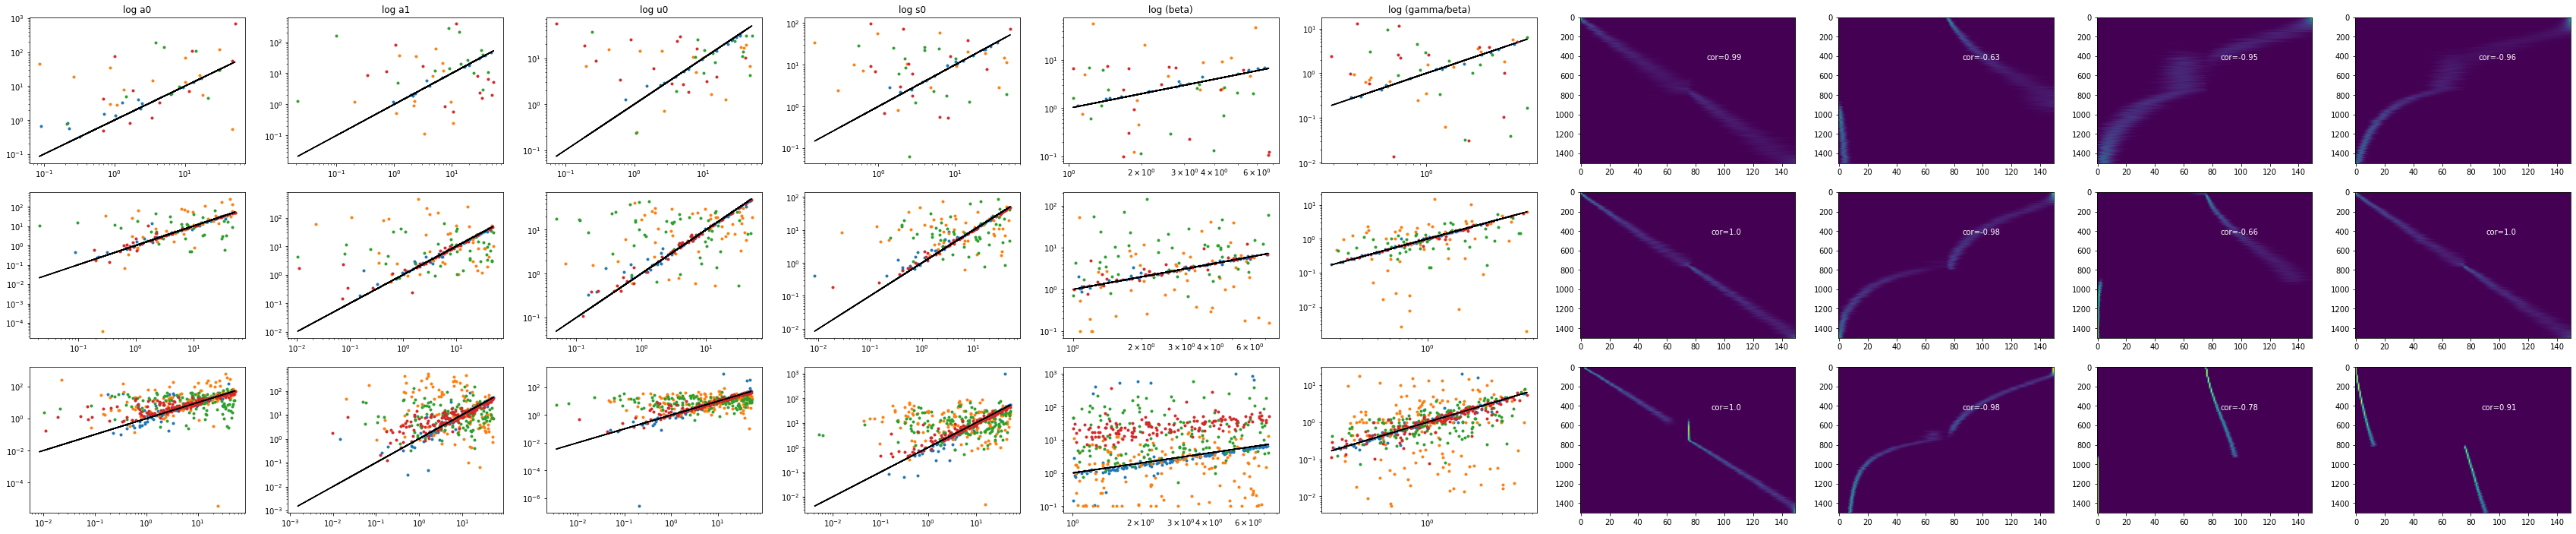

In [78]:
plot_fit_result(1500, warm=False) 

In [ ]:
plot_fit_result(1500, cores=40)

In [ ]:
plot_fit_result(3000, cores=40)

## Including some uninformative genes

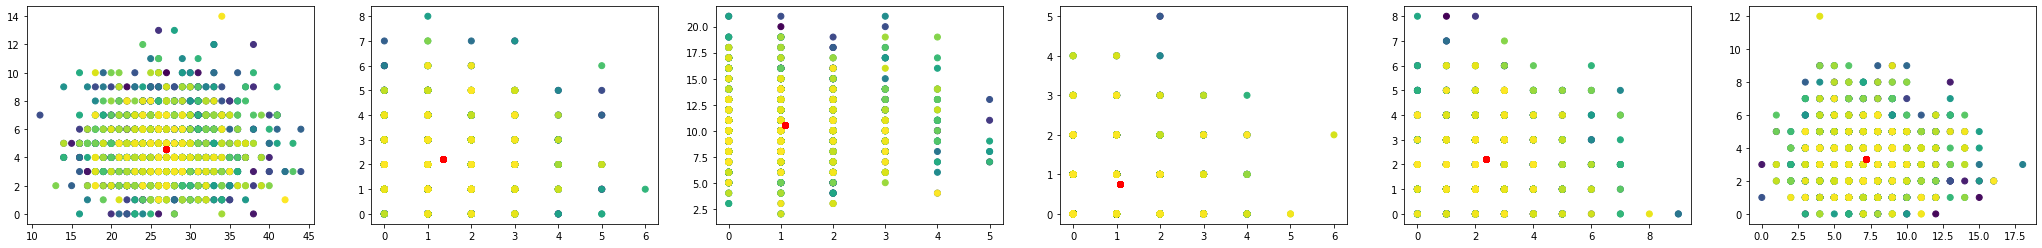

In [15]:
n=1500
t=np.linspace(0,1,n)
r=0.002
tau=(0,0.5,1)
K=2
loga_max=4
logb_max=2
p = int(2*n*r) 
true_p=0

np.random.seed(42)
theta=np.zeros((p,K+4))
theta[:,0]=np.exp(np.random.uniform(0,loga_max,size=p))-1
theta[:,1]=np.exp(np.random.uniform(0,loga_max,size=p))-1
theta[:,-4]=np.exp(np.random.uniform(0,loga_max,size=p))-1
theta[:,-3]=np.exp(np.random.uniform(0,loga_max,size=p))-1
theta[:,-2]=np.exp(np.random.uniform(0,logb_max,size=p))
theta[:,-1]=np.exp(np.random.uniform(0,logb_max,size=p))
theta[true_p:,-2]=1
theta[true_p:,-1]=theta[true_p:,-4]/theta[true_p:,-3]
theta[true_p:,0]=theta[true_p:,-4]
theta[true_p:,1]=theta[true_p:,-4]


Y = get_Y(theta,t,tau)
X = np.random.poisson(Y)

fig, ax = plt.subplots(1,p,figsize=(6*p,4))
for i in range(p):
    ax[i].scatter(X[:,i,0],X[:,i,1],c=t);
    ax[i].scatter(Y[:,i,0],Y[:,i,1],c='r');

In [69]:
def plot_uninformative_genes(thetas, theta_hats, weights, n=1500,rs=[0.01, 1/30],seeds=[42,63],K=2):
    fig, axs = plt.subplots(len(rs), K+4, figsize=(6*(K+4),4*len(rs)))
    binwidth = 0.2
    for i in range(len(rs)):
        true_p = int(n*rs[i])  
        p = 2*true_p
        for j in range(len(seeds)):
            idx=i*len(seeds)+j
            theta=thetas[idx]
            theta_hat=theta_hats[idx]
            weight=weights[idx]
            for k in range(K):
                data = theta_hat[true_p:,k]-theta_hat[true_p:,K]
                axs[i,k].hist(data, bins=np.arange(min(data)-0.5*binwidth, max(data) + 0.5*binwidth, binwidth),alpha=0.3,label="#zero="+str(int(np.sum(data<1e-3))))
                axs[i,k].legend()
                
            axs[i,K].loglog(theta[true_p:,K],theta_hat[true_p:,K],'.')
            axs[i,K].loglog(theta[true_p:,K],theta[true_p:,K],'k')
            axs[i,K+1].loglog(theta[true_p:,K+1],theta_hat[true_p:,K+1],'.')
            axs[i,K+1].loglog(theta[true_p:,K+1],theta[true_p:,K+1],'k')


            axs[i,K+2].loglog(theta[true_p:,K+2],theta_hat[true_p:,K+2],'.')
            axs[i,K+2].loglog(theta[true_p:,K+2],theta[true_p:,K+2],'k')
            axs[i,K+3].loglog(theta[true_p:,K+3]/theta[true_p:,K+2],theta_hat[true_p:,K+3]/theta_hat[true_p:,K+2],'.')
            axs[i,K+3].loglog(theta[true_p:,K+3]/theta[true_p:,K+2],theta[true_p:,K+3]/theta[true_p:,K+2],'k')


        # add title
        for k in range(K):
            axs[0,k].set_title("a"+str(k)+" - u0");    

        axs[0,K].set_title("log u0");
        axs[0,K+1].set_title("log s0");

        axs[0,K+2].set_title("log (beta)");
        axs[0,K+3].set_title("log (gamma/beta)");


### No penalty

In [ ]:
thetas, theta_hats, weights = get_fit_result(n=1500, rs=[0.01, 1/30], add_null=True, seeds=[42,63], cores=10)

**plot uninformative genes**

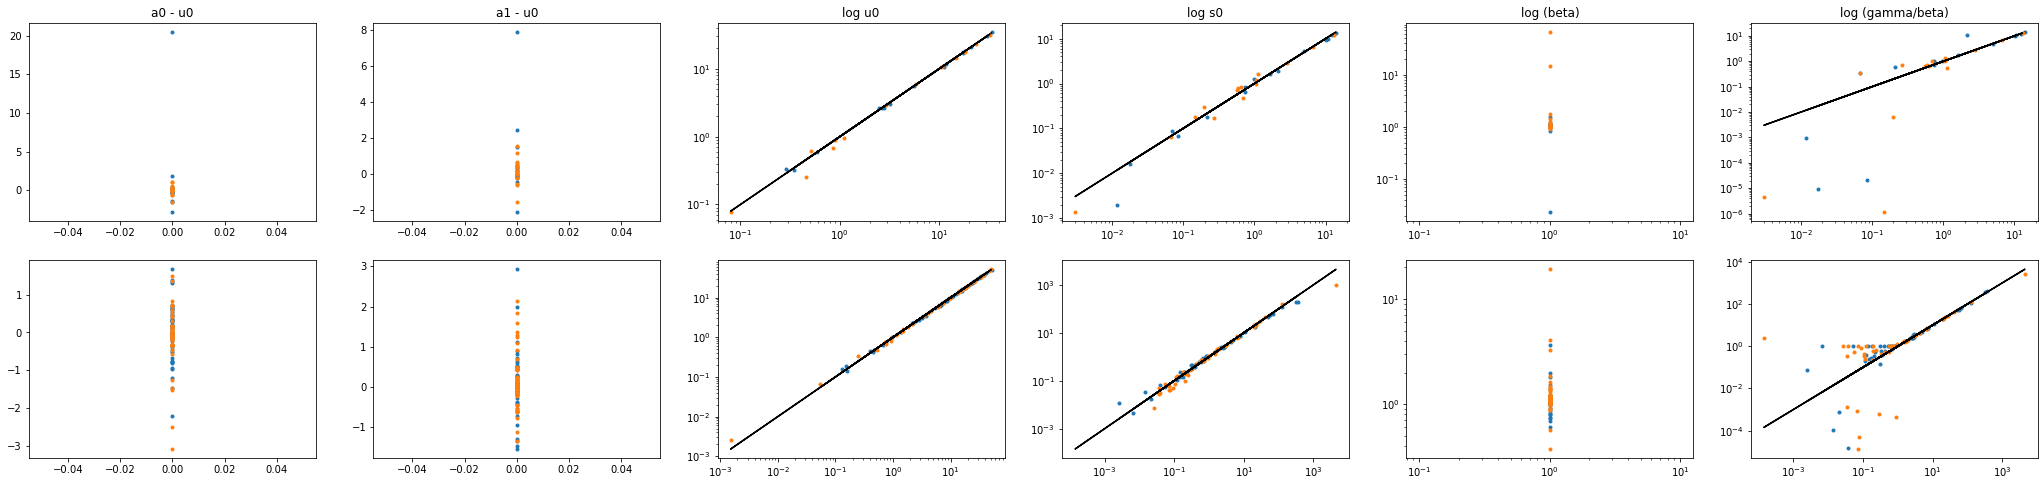

In [36]:
n=1500
rs=[0.01, 1/30]
seeds=[42,63]
K=2

fig, axs = plt.subplots(len(rs), K+4, figsize=(6*(K+4),4*len(rs)))
for i in range(len(rs)):
    true_p = int(n*rs[i])  
    p = 2*true_p
    for j in range(len(seeds)):
        idx=i*len(seeds)+j
        theta=thetas[idx]
        theta_hat=theta_hats[idx]
        weight=weights[idx]
        for k in range(K):
            axs[i,k].plot(theta[true_p:,k]-theta[true_p:,K],theta_hat[true_p:,k]-theta_hat[true_p:,K],'.')
            axs[i,k].plot(theta[true_p:,k]-theta[true_p:,K],theta[true_p:,k]-theta[true_p:,K],'k')
                
        axs[i,K].loglog(theta[true_p:,K],theta_hat[true_p:,K],'.')
        axs[i,K].loglog(theta[true_p:,K],theta[true_p:,K],'k')
        axs[i,K+1].loglog(theta[true_p:,K+1],theta_hat[true_p:,K+1],'.')
        axs[i,K+1].loglog(theta[true_p:,K+1],theta[true_p:,K+1],'k')


        axs[i,K+2].loglog(theta[true_p:,K+2],theta_hat[true_p:,K+2],'.')
        axs[i,K+2].loglog(theta[true_p:,K+2],theta[true_p:,K+2],'k')
        axs[i,K+3].loglog(theta[true_p:,K+3]/theta[true_p:,K+2],theta_hat[true_p:,K+3]/theta_hat[true_p:,K+2],'.')
        axs[i,K+3].loglog(theta[true_p:,K+3]/theta[true_p:,K+2],theta[true_p:,K+3]/theta[true_p:,K+2],'k')

            
    # add title
    for k in range(K):
        axs[0,k].set_title("a"+str(k)+" - u0");    
            
    axs[0,K].set_title("log u0");
    axs[0,K+1].set_title("log s0");
    
    axs[0,K+2].set_title("log (beta)");
    axs[0,K+3].set_title("log (gamma/beta)");
    

**plot informative genes**

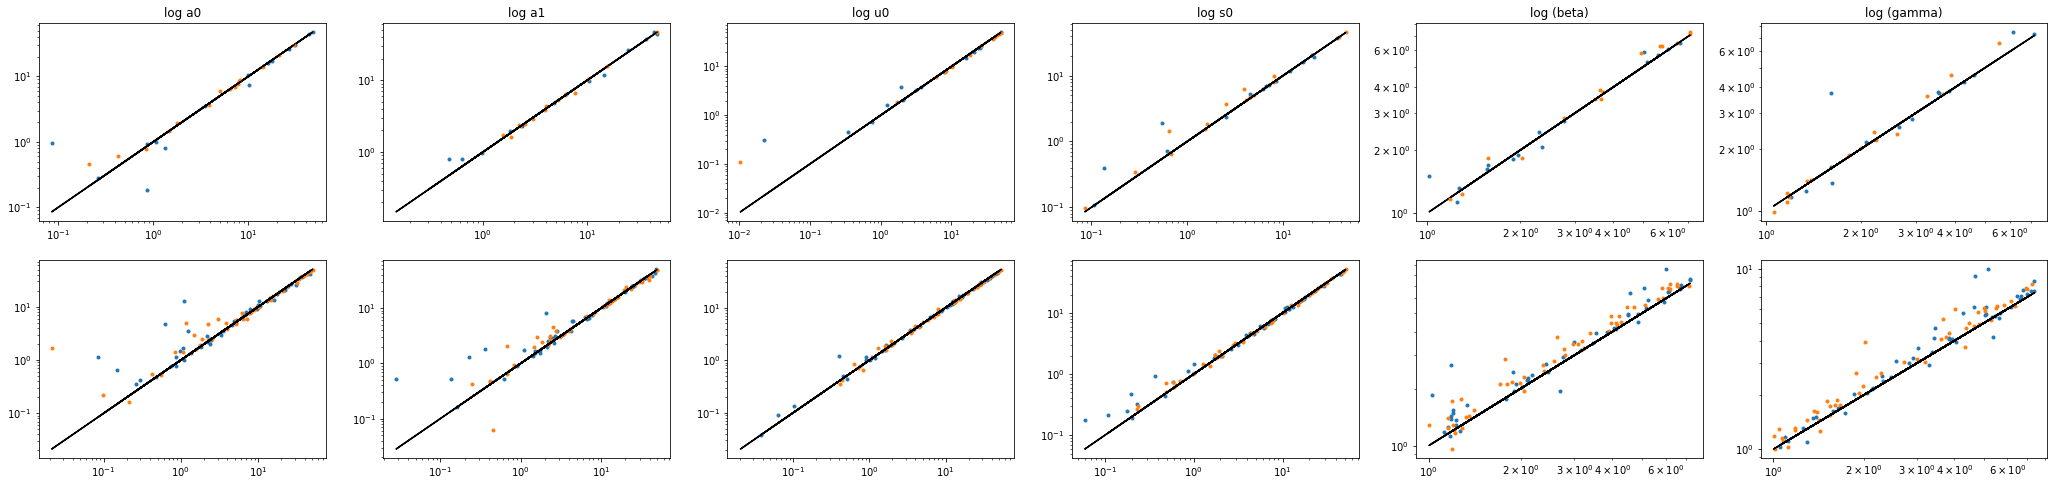

In [37]:
n=1500
rs=[0.01, 1/30]
seeds=[42,63]
K=2

fig, axs = plt.subplots(len(rs), K+4, figsize=(6*(K+4),4*len(rs)))
for i in range(len(rs)):
    true_p = int(n*rs[i])  
    p = 2*true_p
    for j in range(len(seeds)):
        idx=i*len(seeds)+j
        theta=thetas[idx]
        theta_hat=theta_hats[idx]
        weight=weights[idx]
        for k in range(K+4):
            axs[i,k].loglog(theta[:true_p,k],theta_hat[:true_p,k],'.')
            axs[i,k].loglog(theta[:true_p,k],theta[:true_p,k],'k')
            
    # add title
    for k in range(K):
        axs[0,k].set_title("log a"+str(k));    
            
    axs[0,K].set_title("log u0");
    axs[0,K+1].set_title("log s0");
    
    axs[0,K+2].set_title("log (beta)");
    axs[0,K+3].set_title("log (gamma)");
    

### Penalty 0.001

In [72]:
thetas_3, theta_hats_3, weights_3 = get_fit_result(n=1500, rs=[0.01, 1/30], relative_penalty=0.001, add_null=True, seeds=[42,63], cores=30)

100%|██████████| 20/20 [04:50<00:00, 14.53s/it]


/tmp/ipykernel_12526/2595746709.py:25: RuntimeWarning: divide by zero encountered in true_divide
  axs[i,K+3].loglog(theta[true_p:,K+3]/theta[true_p:,K+2],theta_hat[true_p:,K+3]/theta_hat[true_p:,K+2],'.')
/tmp/ipykernel_12526/2595746709.py:25: RuntimeWarning: divide by zero encountered in true_divide
  axs[i,K+3].loglog(theta[true_p:,K+3]/theta[true_p:,K+2],theta_hat[true_p:,K+3]/theta_hat[true_p:,K+2],'.')
/tmp/ipykernel_12526/2595746709.py:25: RuntimeWarning: divide by zero encountered in true_divide
  axs[i,K+3].loglog(theta[true_p:,K+3]/theta[true_p:,K+2],theta_hat[true_p:,K+3]/theta_hat[true_p:,K+2],'.')


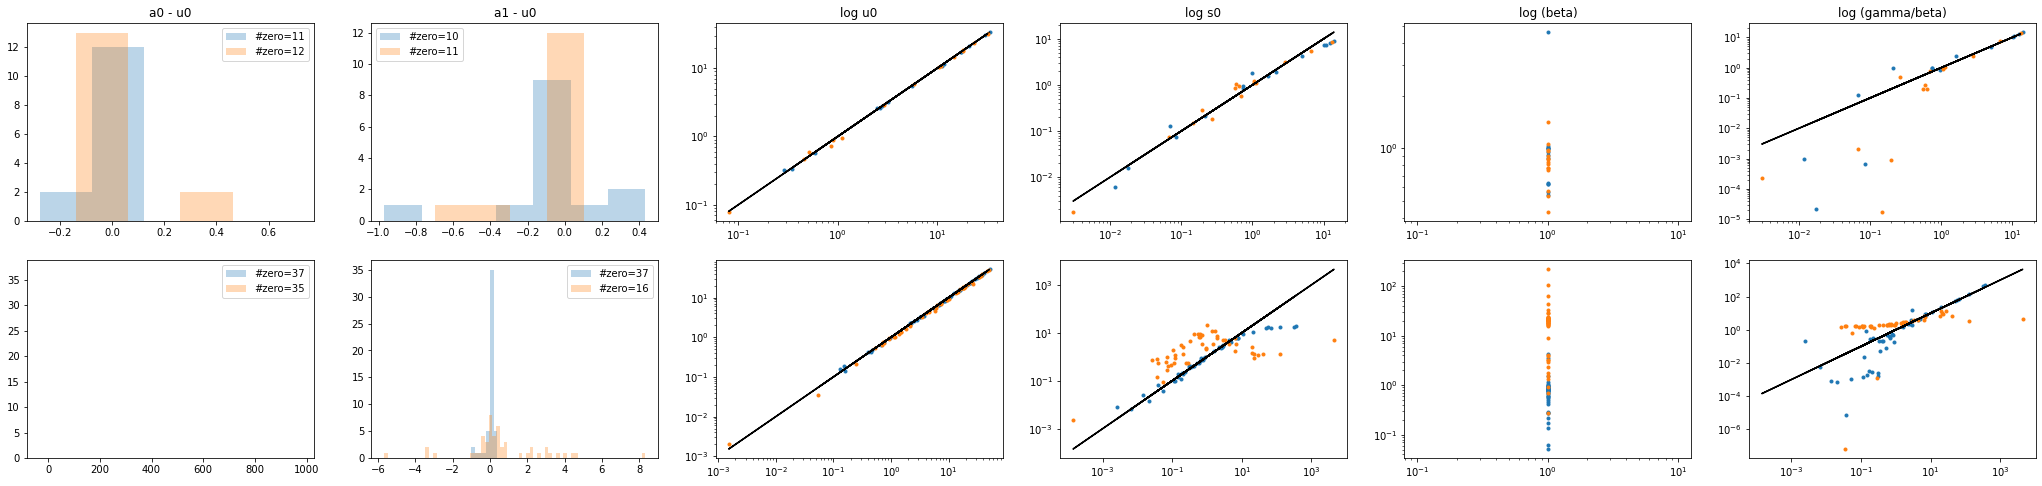

In [73]:
plot_uninformative_genes(thetas_3, theta_hats_3, weights_3, n=1500,rs=[0.01, 1/30],seeds=[42,63],K=2)

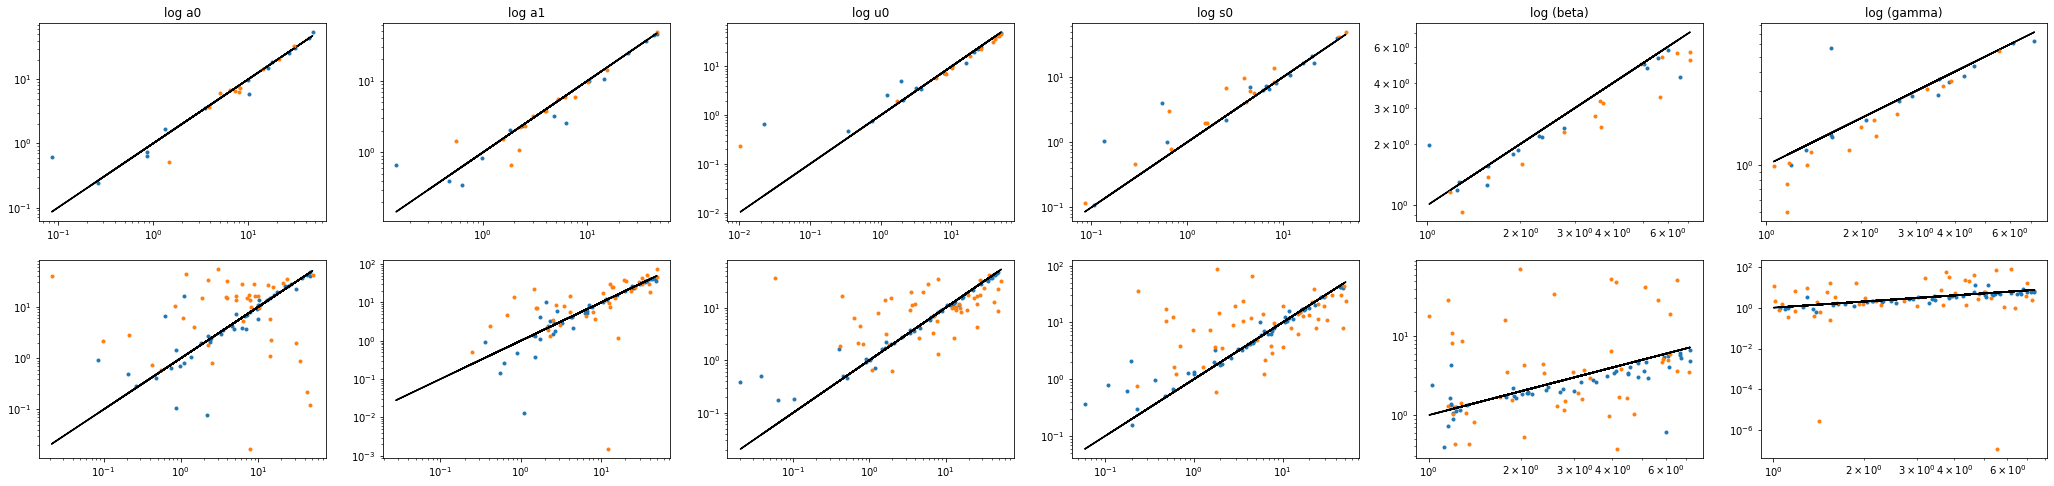

In [40]:
n=1500
rs=[0.01, 1/30]
seeds=[42,63]
K=2

fig, axs = plt.subplots(len(rs), K+4, figsize=(6*(K+4),4*len(rs)))
for i in range(len(rs)):
    true_p = int(n*rs[i])  
    p = 2*true_p
    for j in range(len(seeds)):
        idx=i*len(seeds)+j
        theta=thetas[idx]
        theta_hat=theta_hats[idx]
        weight=weights[idx]
        for k in range(K+4):
            axs[i,k].loglog(theta[:true_p,k],theta_hat[:true_p,k],'.')
            axs[i,k].loglog(theta[:true_p,k],theta[:true_p,k],'k')
            
    # add title
    for k in range(K):
        axs[0,k].set_title("log a"+str(k));    
            
    axs[0,K].set_title("log u0");
    axs[0,K+1].set_title("log s0");
    
    axs[0,K+2].set_title("log (beta)");
    axs[0,K+3].set_title("log (gamma)");
    

### Penalty 0.01

In [41]:
thetas_2, theta_hats_2, weights_2 = get_fit_result(n=1500, rs=[0.01, 1/30], relative_penalty=0.01, add_null=True, seeds=[42,63], cores=30)

100%|██████████| 20/20 [05:10<00:00, 15.53s/it]


/tmp/ipykernel_12526/2595746709.py:25: RuntimeWarning: divide by zero encountered in true_divide
  axs[i,K+3].loglog(theta[true_p:,K+3]/theta[true_p:,K+2],theta_hat[true_p:,K+3]/theta_hat[true_p:,K+2],'.')
/tmp/ipykernel_12526/2595746709.py:25: RuntimeWarning: divide by zero encountered in true_divide
  axs[i,K+3].loglog(theta[true_p:,K+3]/theta[true_p:,K+2],theta_hat[true_p:,K+3]/theta_hat[true_p:,K+2],'.')
/tmp/ipykernel_12526/2595746709.py:25: RuntimeWarning: invalid value encountered in true_divide
  axs[i,K+3].loglog(theta[true_p:,K+3]/theta[true_p:,K+2],theta_hat[true_p:,K+3]/theta_hat[true_p:,K+2],'.')
/tmp/ipykernel_12526/2595746709.py:25: RuntimeWarning: divide by zero encountered in true_divide
  axs[i,K+3].loglog(theta[true_p:,K+3]/theta[true_p:,K+2],theta_hat[true_p:,K+3]/theta_hat[true_p:,K+2],'.')


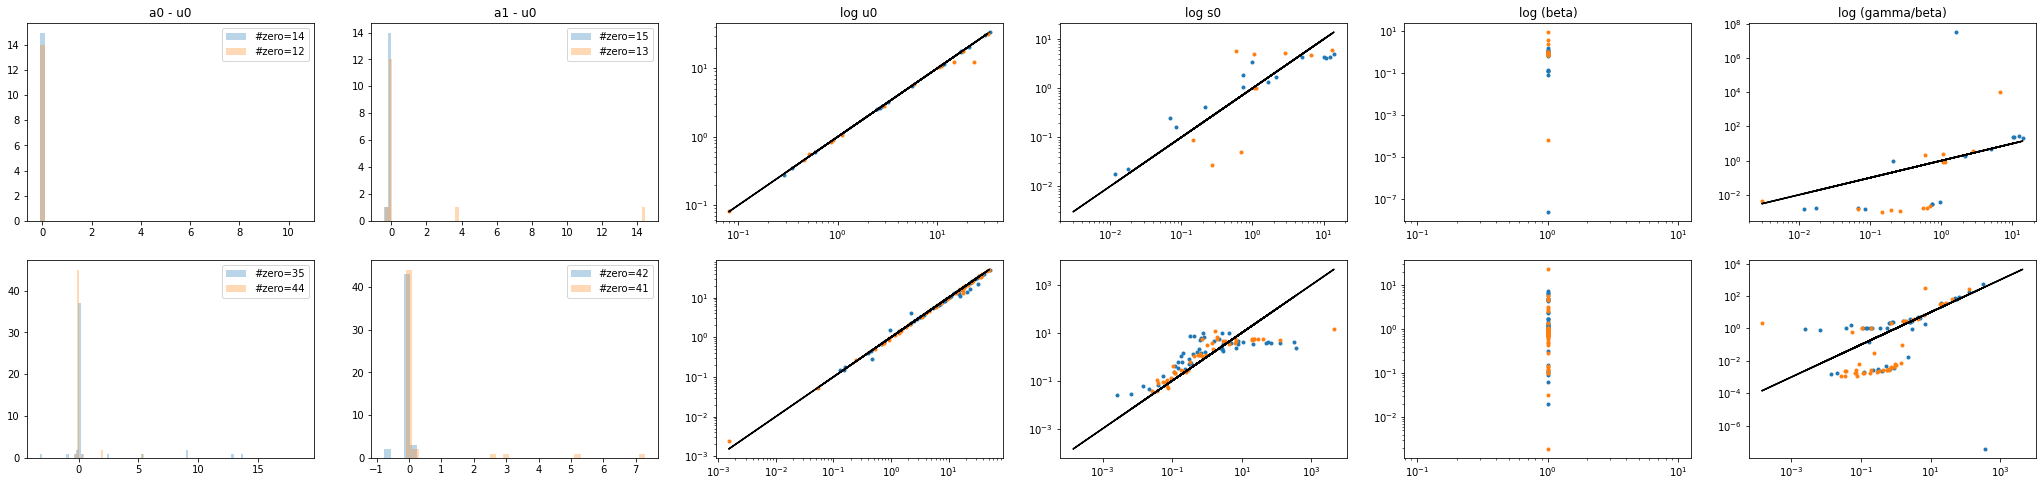

In [70]:
plot_uninformative_genes(thetas, theta_hats, weights, n=1500,rs=[0.01, 1/30],seeds=[42,63],K=2)

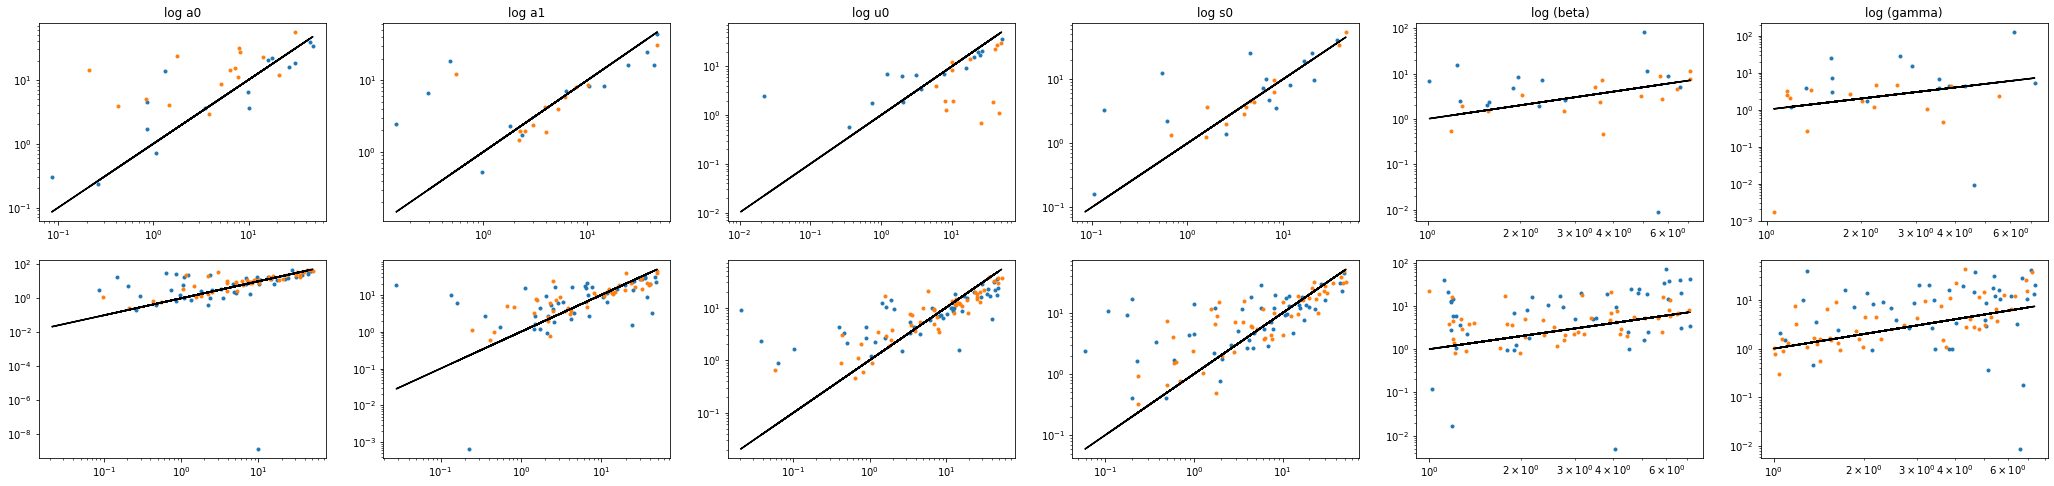

In [71]:
n=1500
rs=[0.01, 1/30]
seeds=[42,63]
K=2

fig, axs = plt.subplots(len(rs), K+4, figsize=(6*(K+4),4*len(rs)))
for i in range(len(rs)):
    true_p = int(n*rs[i])  
    p = 2*true_p
    for j in range(len(seeds)):
        idx=i*len(seeds)+j
        theta=thetas[idx]
        theta_hat=theta_hats[idx]
        weight=weights[idx]
        for k in range(K+4):
            axs[i,k].loglog(theta[:true_p,k],theta_hat[:true_p,k],'.')
            axs[i,k].loglog(theta[:true_p,k],theta[:true_p,k],'k')
            
    # add title
    for k in range(K):
        axs[0,k].set_title("log a"+str(k));    
            
    axs[0,K].set_title("log u0");
    axs[0,K+1].set_title("log s0");
    
    axs[0,K+2].set_title("log (beta)");
    axs[0,K+3].set_title("log (gamma)");
    

### Penalty 0.1

100%|██████████| 20/20 [04:43<00:00, 14.19s/it]


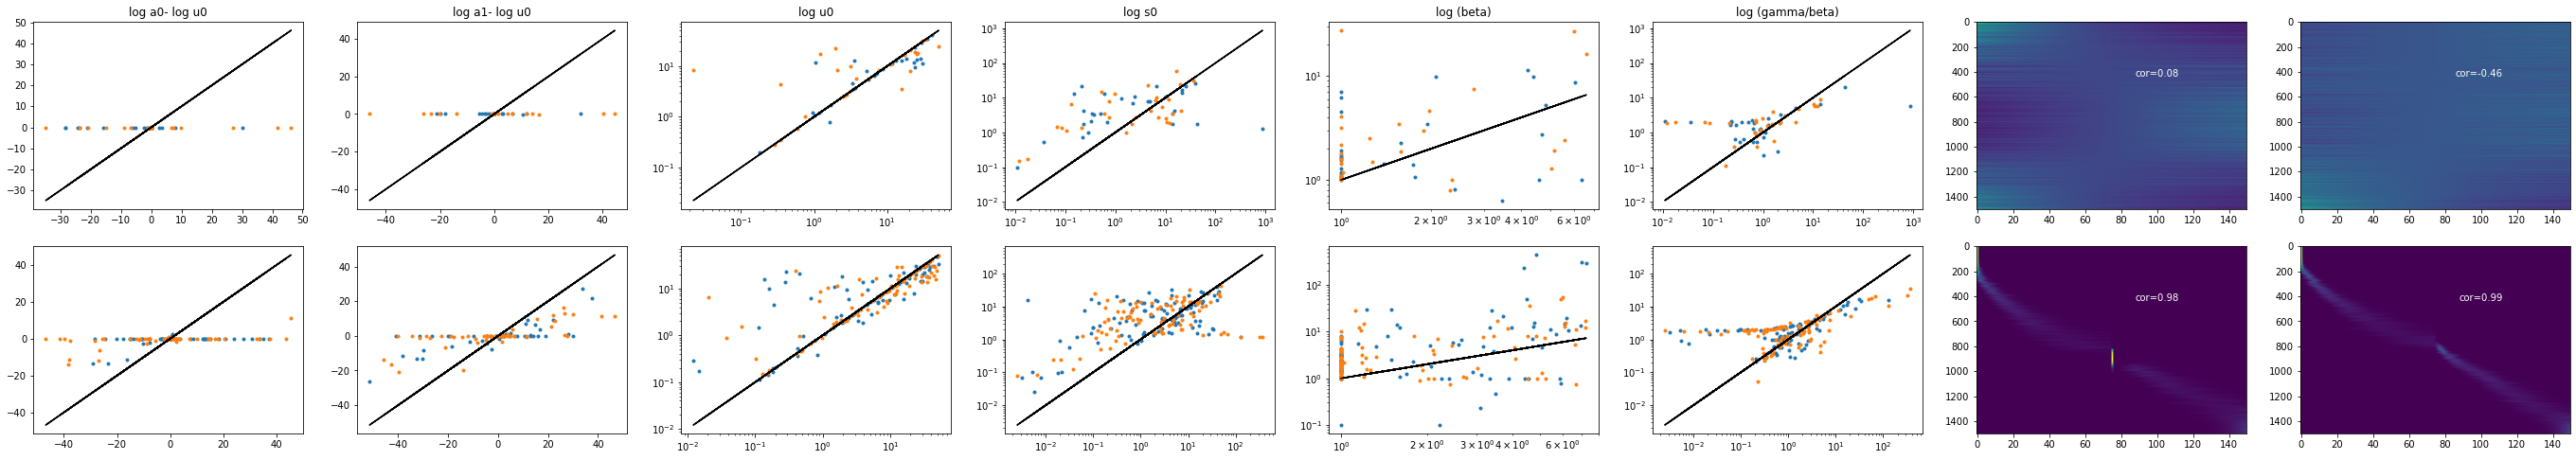

In [17]:
plot_fit_result(n=1500, rs=[0.01, 1/30], add_null=True, relative_penalty=0.1, seeds=[21,42], cores=40)